In [1]:
#%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sympy import *
from scipy.interpolate import CubicSpline
import pandas as pd
import math
import os
import re

#  Power Spectrum (Class Calculation)

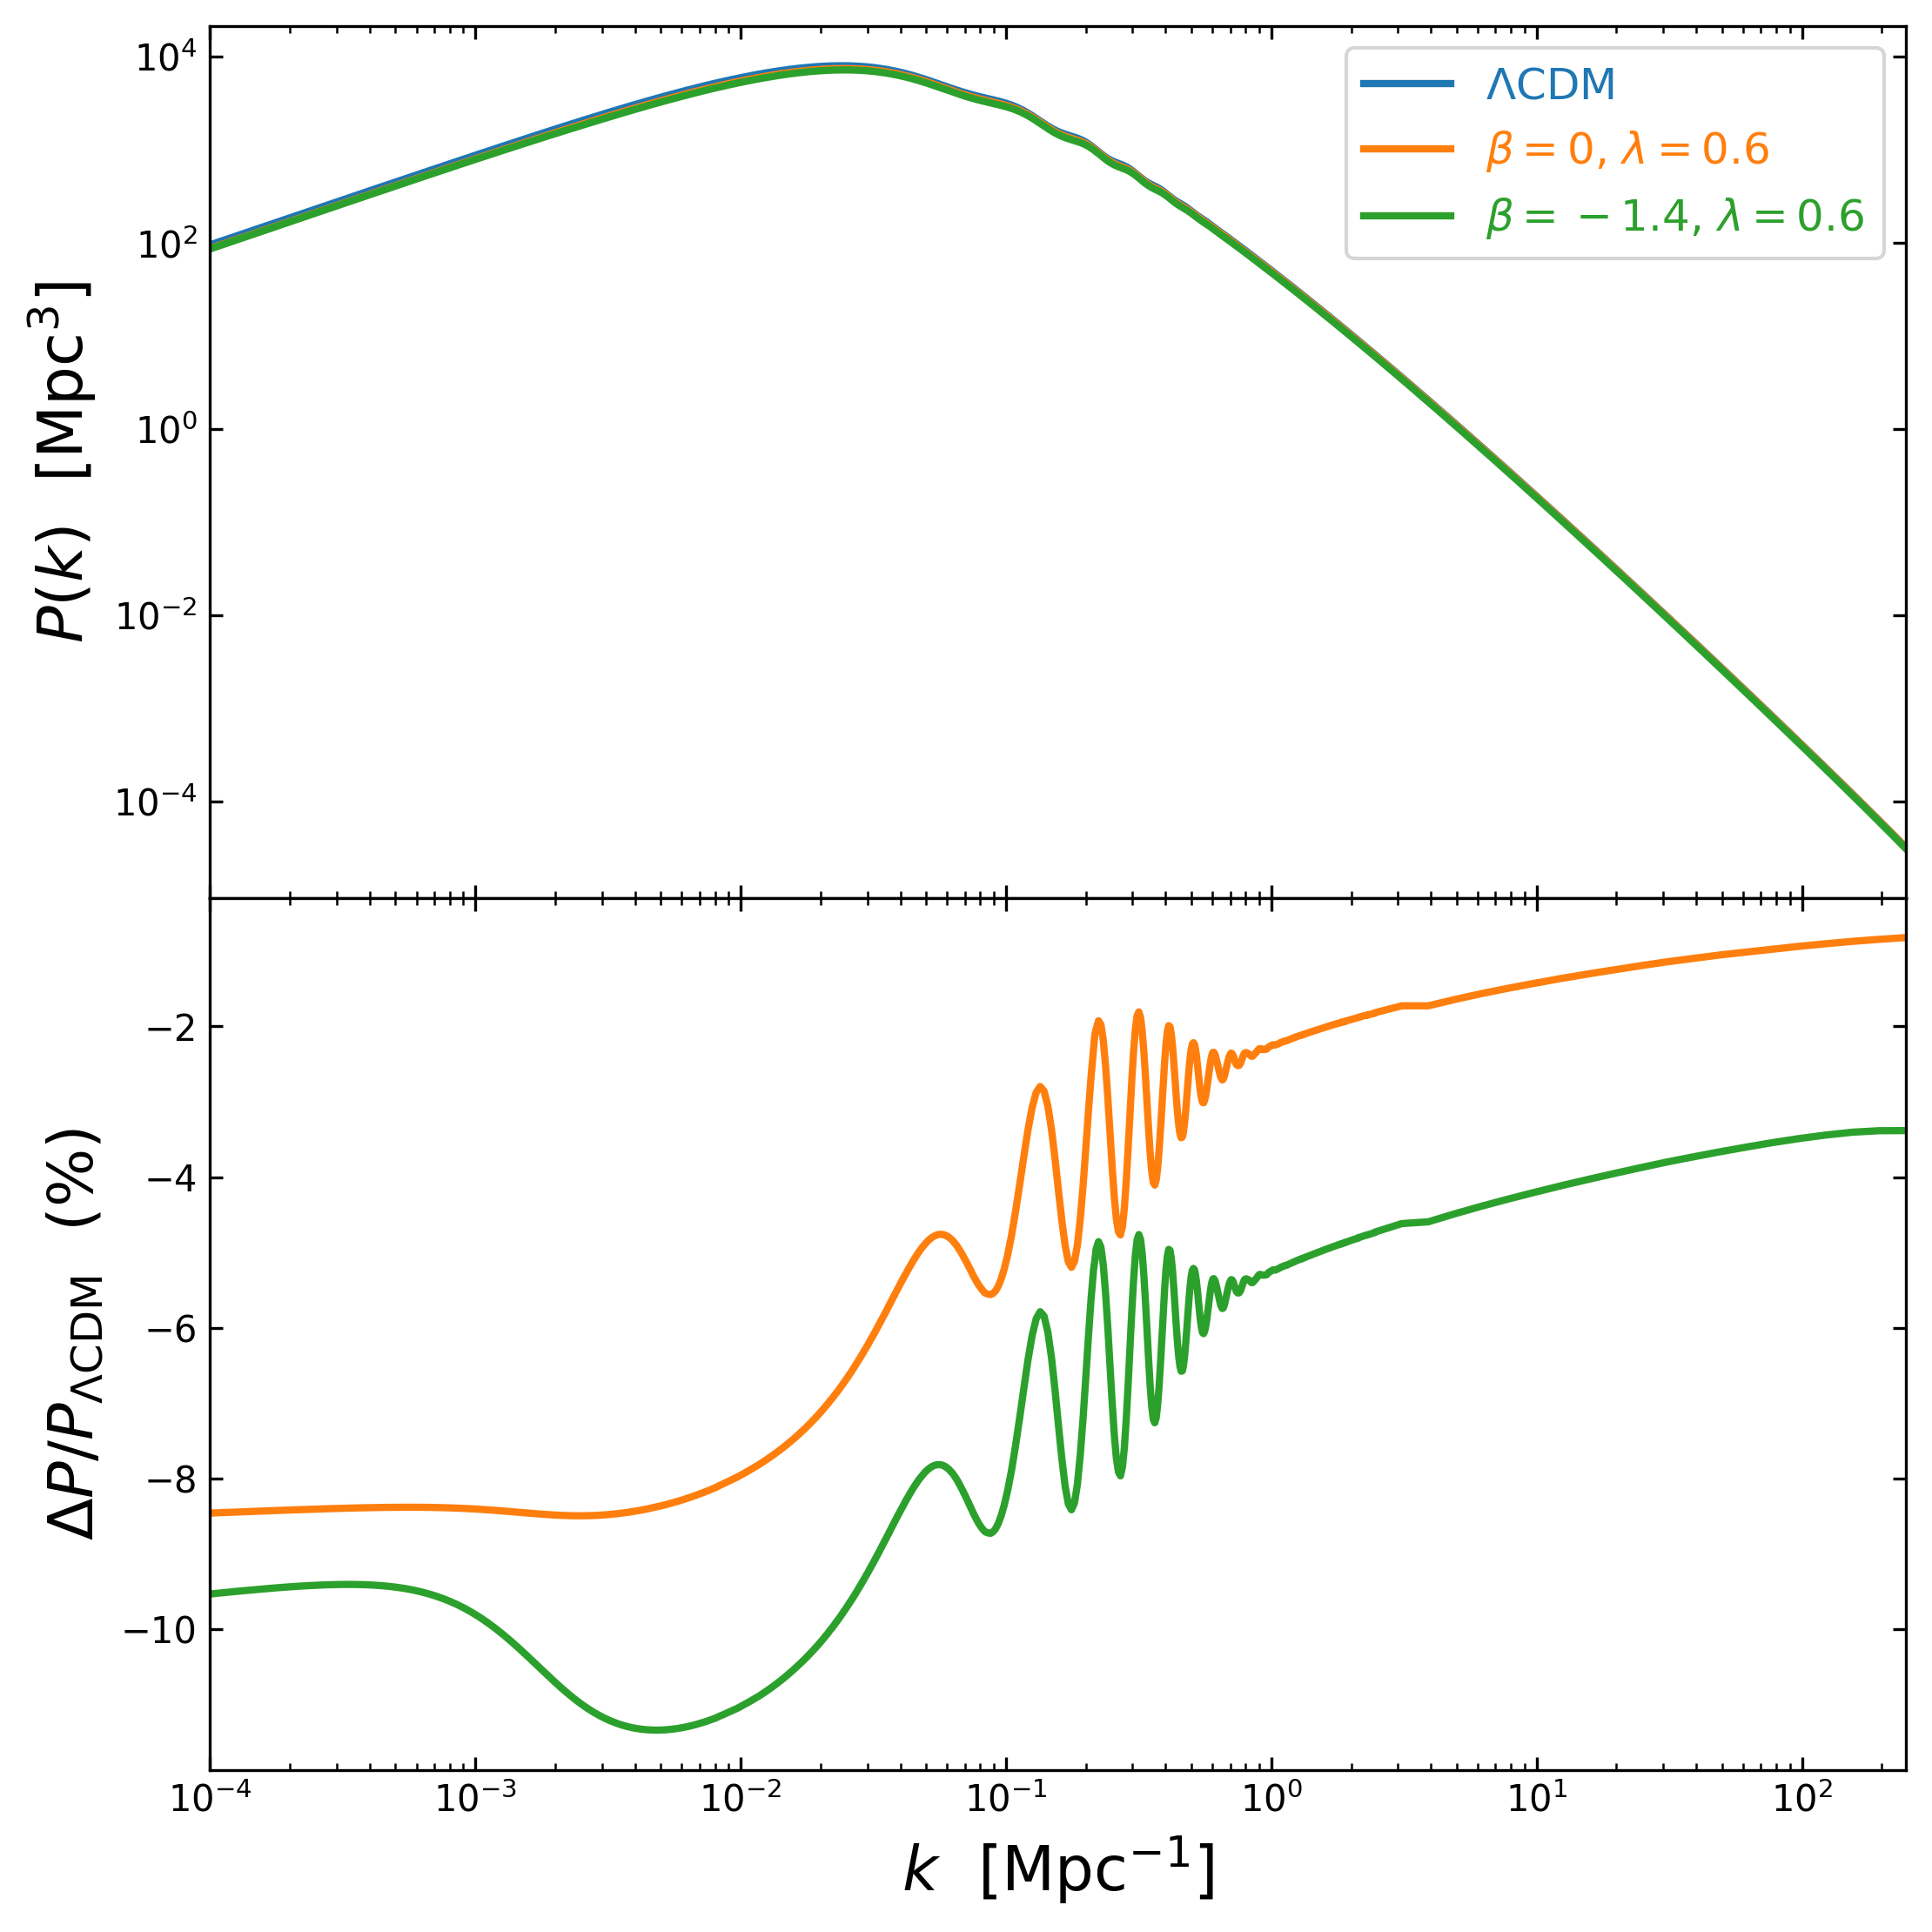

In [2]:
# --- Update these paths if needed ---
files = {
    "$\\Lambda$CDM": r"/Users/kinho123/Downloads/mphil_project/output/DESI_2_Cobaya/LCDM/LCDM/beta_LCDM_00_z1_pk.dat",
    r"$\beta = 0$, $\lambda = 0.6$ ": r"/Users/kinho123/Downloads/mphil_project/output/DESI_2_Cobaya/Lambda_0.6_T3/A0/beta_0_00_z1_pk.dat",
    r"$\beta = -1.4$, $\lambda = 0.6$ ": r"/Users/kinho123/Downloads/mphil_project/output/DESI_2_Cobaya/Lambda_1_T3/A8/beta_-0.2_00_z1_pk.dat",
}

# --- Helpers ---
def parse_redshift_from_header(path):
    """Try to extract redshift z from commented header lines."""
    z = None
    try:
        with open(path, 'r') as f:
            for line in f:
                if not line.strip().startswith("#"):
                    break
                m = re.search(r"redshift\s+z\s*=\s*([0-9.+-eE]+)", line)
                if m:
                    try:
                        z = float(m.group(1))
                    except ValueError:
                        pass
    except Exception:
        pass
    return z

def load_pk(path):
    """
    Load P(k) file with possible header comments (#).
    Returns sorted arrays (k, P) with k>0 and P>0.
    """
    arr = np.loadtxt(path, comments="#", dtype=float)
    if arr.ndim != 2 or arr.shape[1] < 2:
        raise ValueError(f"File {path} does not have two numeric columns.")
    k = arr[:, 0]
    p = arr[:, 1]
    # Keep only positive k and P
    mask = (k > 0) & (p > 0)
    k = k[mask]
    p = p[mask]
    # Sort by k
    order = np.argsort(k)
    k = k[order]
    p = p[order]
    return k, p

def loglog_interp(x_new, x, y):
    """
    Log-log interpolation: interpolate log(y) vs log(x) at log(x_new),
    then exponentiate. Requires x>0, y>0, sorted x.
    """
    log_y_interp = np.interp(np.log(x_new), np.log(x), np.log(y))
    return np.exp(log_y_interp)

# Map each label to its H0 so we can compute h = H0/100
H0_by_label = {
    "$\\Lambda$CDM": 68.02,
    r"$\beta = 0$, $\lambda = 0.6$ ": 67.21,
    r"$\beta = -1.4$, $\lambda = 0.6$ ": 67.78,
}

def to_h_free_units(k_hmpc, p_mpc_over_h3, h):
    """
    Convert k [h/Mpc] -> k_phys [1/Mpc]
            P [(Mpc/h)^3] -> P_phys [Mpc^3]
    """
    k_phys = k_hmpc / h         # k_phys [1/Mpc]
    p_phys = p_mpc_over_h3 * (h**3)  # P_phys [Mpc^3]
    return k_phys, p_phys

# --- Load all datasets (unchanged) ---
data = {}
redshifts = {}
for label, path in files.items():
    if not os.path.isfile(path):
        raise FileNotFoundError(f"Path not found: {path}")
    k, p = load_pk(path)
    data[label] = (k, p)
    redshifts[label] = parse_redshift_from_header(path)

# --- Convert every dataset to h-free units ---
data_hfree = {}
for label, (k_hmpc, p_mpc_over_h3) in data.items():
    H0 = H0_by_label.get(label)
    if H0 is None:
        raise KeyError(f"No H0 provided for label: {label}")
    h = H0 / 100.0
    k_phys, p_phys = to_h_free_units(k_hmpc, p_mpc_over_h3, h)
    data_hfree[label] = (k_phys, p_phys)

# --- Reference LCDM in h-free units ---
ref_label = "$\\Lambda$CDM"
k_ref, p_ref = data_hfree[ref_label]

# --- Determine overlapping k-range across all datasets (h-free) ---
k_min_common = max(k.min() for k, _ in data_hfree.values())
k_max_common = min(k.max() for k, _ in data_hfree.values())
if k_min_common >= k_max_common:
    raise ValueError("No overlapping k-range across the files. Check input files.")

mask_ref = (k_ref >= k_min_common) & (k_ref <= k_max_common)
k_grid = k_ref[mask_ref]
p_ref_overlap = p_ref[mask_ref]

# --- Compute fractional deviations (unit-invariant when done consistently) ---
fractions = {}
def loglog_interp(x_new, x, y):
    log_y_interp = np.interp(np.log(x_new), np.log(x), np.log(y))
    return np.exp(log_y_interp)

for label, (k_phys, p_phys) in data_hfree.items():
    if label == ref_label:
        continue
    p_interp = loglog_interp(k_grid, k_phys, p_phys)
    frac_percent = 100.0 * (p_interp / p_ref_overlap - 1.0)
    fractions[label] = (k_grid, frac_percent)

# --- Plot in h-free units ---
fig, axs = plt.subplots(2, 1, figsize=(7.5, 7.5), dpi=300, sharex=True)

# Top: P(k) in Mpc^3 vs k in 1/Mpc (log-log)
ax0 = axs[0]
colors = {}
for label, (k_phys, p_phys) in data_hfree.items():
    line, = ax0.loglog(k_phys, p_phys, lw=2, label=label)
    colors[label] = line.get_color()
ax0.set_ylabel(r"$P(k)\ \ [\mathrm{Mpc}^3]$", fontsize=17)
ax0.legend(frameon=True, labelcolor='linecolor', fontsize=12)

# Bottom: fractional deviation from LCDM (percent) vs k in 1/Mpc (semilog-x)
ax1 = axs[1]
for label, (kx_phys, frac) in fractions.items():
    ax1.semilogx(kx_phys, frac, lw=2, label=label, color=colors.get(label))
ax1.set_xlabel(r"$k\ \ [\mathrm{Mpc}^{-1}]$", fontsize=17)
ax1.set_ylabel(r"$\Delta P / P_{\Lambda{\rm CDM}}\ \ (\%)$", fontsize=17)
#ax1.legend(frameon=True, labelcolor='linecolor', fontsize=12)

# k-range (adjust if needed, now in 1/Mpc)
ax1.set_xlim(max(k_min_common, 1e-4), k_max_common)

# Ticks & layout
for ax in axs:
    ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
plt.tight_layout()
plt.subplots_adjust(hspace=0, wspace=0)
plt.savefig(r'/Users/kinho123/Downloads/mphil_project/pwv/power_spectrum.pdf', bbox_inches='tight')

# Compare the power spectrum ratios for different values of lambda 

# Calculate linear pairwise velocity ($v_{pp}$)

In [3]:
from scipy import integrate
from scipy import interpolate
# ------------------------------------------------------------------------------- #
# --------------------------------- linear theory ------------------------------- #
#base_lin = '/mnt2/wzzhang/newrun_2023_June/ICs/linear_pk/z0/cmbonly_%s-cdm-z0.txt'
prior = "T3"
case = "A0"
Lambda = "0.6"
scf_beta= "0"

base_lin = '/Users/kinho123/Downloads/mphil_project/output/DESI_2_Cobaya/Lambda_{}_{}/{}/beta_{}_00_z1_pk.dat'.format(Lambda, prior, case, scf_beta)

def xi_lin_from_pk(rr,fpk,k_tmp):
    def xi_inte(k):
        if(k<=k_tmp[0] or k>=k_tmp[-1]):
            pk_tmp = 0
        else:
            pk_tmp = fpk(k)
        # if(rr!=0):
        #     tmp = k*pk_tmp/2/np.pi/np.pi/rr
        # else:
        #     tmp = k*k*pk_tmp/2/np.pi/np.pi
        tmp = k*pk_tmp/2/np.pi/np.pi    
        return tmp
    xitmp, xierr_tmp = integrate.quad(xi_inte, 1e-8, np.inf, weight='sin', wvar=rr)
    return xitmp/rr

def xibar_inte(y,fxi,rad_tmp):
    if(y>=rad_tmp[0] and y<=rad_tmp[-1]):
        tmp = fxi(y)
    elif(y<rad_tmp[0]):
        tmp = fxi(rad_tmp[0])
    else:
        tmp = 0
    return tmp*y*y

def cal_xibar(r,fxi,rad_tmp):
    xibar_tmp, xibarerr_tmp = integrate.quad(xibar_inte, 1e-8, r, args=(fxi,rad_tmp))
    return xibar_tmp*3/pow(r,3)

def cal_pwv_lin(file_name, hh, Om, rad):
    # ------------------------------ #
    # ----- read camb linear pk ---- #
    #% mxi
    k, pk = np.loadtxt(file_name, skiprows=1, unpack=True)
    k *= hh; pk /= hh**3
    fpk = interpolate.interp1d(k, pk, kind='cubic')
    # ------------------------------ #
    # -------- cal linear xi ------- #
    rad_tmp = np.logspace(np.log10(0.1),3)
    xi_lin = np.array([xi_lin_from_pk(rr,fpk,k) for rr in rad_tmp])
    fxi = interpolate.interp1d(rad_tmp, xi_lin, kind='cubic')
    # ------------------------------ #
    # -- cal linear xi bar and xi -- #
    xib_lin = np.array([cal_xibar(rr,fxi,rad_tmp) for rr in rad])
    # print(xibar_lin)
    xi_lin = np.array([xi_lin_from_pk(rr,fpk,k) for rr in rad])
    growth_rate = Om**0.55
    # ------------------------------ #
    # ------- cal linear pwv ------- #
    xibb_lin = xib_lin/(1+xi_lin)
    pwv_lin = -(2/3)*100*hh*rad*growth_rate*xibb_lin

    return pwv_lin, xi_lin

h_0 = 67.21*1e-2
Omega_m =  0.3097
max_mpc = 70
num_point = 50
r_lin = np.linspace(1, max_mpc, num_point) # in unit of mpc
linear_vpp = cal_pwv_lin(base_lin, h_0, Omega_m, r_lin)[0]
linear_vpp[(num_point*50)//max_mpc], r_lin[(num_point*50)//max_mpc]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:25: IntegrationWarning: Bad integrand behavior occurs within one or more of the cycles.
  Location and type of the difficulty involved can be determined from 
  the vector info['ierlist'] obtained with full_output=1.


(-94.55394200917914, 50.285714285714285)

# Calculate sigma_12 (nonlinear P(k))

In [3]:
from scipy.integrate import simps

z = np.array([0, 0.5 ,1, 2, 3, 4, 5, 9, 49, 127])
sorted_indices = np.argsort(z) + 1 
r_nonlin =  np.linspace(1, 18, 20)

def cal_sigma_12(prior, case, Lambda, scf_beta, z):


    base_non_lin = np.array(['/Users/kinho123/Downloads/output/Lambda_{}_{}/{}/beta_{}_00_z{}_pk_nl.dat'.format(Lambda, prior, case, scf_beta, i) 
                              for i in sorted_indices])
    xi_non_lin = np.array([cal_pwv_lin(i, h_0, Omega_m , r_nonlin)[1] for i in base_non_lin])
    
    
    
    a = np.array([1/(1+i) for i in z])
    a_sorted = np.sort(a)[::-1]
    
    # Step 1: Integrate over r for each fixed z
    integrated_over_r = np.zeros(len(a))

    for i in range(len(a)):
        integrated_over_r[i] = simps(xi_non_lin[i]*r_nonlin, r_nonlin)

    #Step 2: Integrate the result over z
    final_integral = simps(integrated_over_r, a_sorted )
    int_I_over_I_1 = final_integral/(integrated_over_r[0])
    v_12 = (3/2)*(Omega_m)*(h_0*100)**2*1*integrated_over_r[0]*(1-int_I_over_I_1)
    sigma_12_squared = (2/3)*v_12
    sigma_12 = (sigma_12_squared)**(1/2)
    return sigma_12
non_lin_sigma_pp = cal_sigma_12(prior, case, Lambda, scf_beta, z)
non_lin_sigma_pp

OSError: /Users/kinho123/Downloads/output/Lambda_0.6_T3/A0/beta_0_00_z1_pk_nl.dat not found.

In [4]:
#non_lin_sigma_pp = 499.9462549426548
non_lin_sigma_pp = 555.1643174103932

# Extract $H_0$ from files for converting mpc/h to mpc

In [5]:
import numpy as np

# Prepare case and Lambda values
case = ["A{}".format(i) for i in range(0, 10)]
scf_beta = ["-1.4", "-0.8", "-0.5"]
scf_beta_f = ["0"] + [item for item in scf_beta for _ in range(3)]
lambda_values = ["0.6"] + ["0.6", "1", "1.4"] * 3
prior = "T3"

# Construct mean_file_dir
mean_file_dir = [
    r"/Users/kinho123/Downloads/mphil_project/output/Cobaya_IDE_DESI2/{}.txt".format(i)
    for i in case
]

# Initialize h_0 outside the loop
h_0_case = np.array([])
Omega_m_case = np.array([])

# Process each file
for file_path in mean_file_dir:
    parameter_values = {}
    with open(file_path, 'r') as file:
        lines = file.readlines()
        # Skip the header line (first line)
        for line in lines[1:]:
            line = line.strip()
            if line:  # Check if the line is not empty
                parts = line.split()
                param_parts = []
                i = 0
                while i < len(parts) and not (parts[i][0].isdigit() or parts[i].startswith('(')):
                    param_parts.append(parts[i])
                    i += 1
                param = ' '.join(param_parts)
                if i < len(parts):
                    value_str = parts[i]
                    if value_str.startswith('('):
                        # For A_s: extract the number after '('
                        central_str = value_str[1:]  # remove '('
                        value = float(central_str) * 1e-9  # Assuming × 10^-9 for A_s
                    else:
                        value = float(value_str)
                    # Store the parameter and its central value
                    parameter_values[param] = value

    # Check if 'H_0' is in the parameter values (note the underscore)
    H0_value = parameter_values.get('H_0')
    if H0_value is not None:
        h_0_case = np.append(h_0_case, round(H0_value * 1e-2, 6))
    
    # Check if 'omega_m' is in the parameter values (lowercase omega)
    Omega_m_value = parameter_values.get('omega_m')
    if Omega_m_value is not None:
        Omega_m_case = np.append(Omega_m_case, round(Omega_m_value, 6))

# Pairwise Velocity

In [130]:
# Only include this in a Jupyter Notebook
%matplotlib inline
plt.ion()
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec
from dataclasses import dataclass
from matplotlib import colors as mcolors

ref_case = 0
# Add this at the top of your code
TABLEAU_COLORS = list(mcolors.TABLEAU_COLORS.values()) 
TABLEAU_COLORS.insert(0, 'purple')
# Define parameters
prior = "T3_DESI"
vel_type = ["particle", "halo"]
halo_mass = ["1.0e+11_1.0e+13", "1.0e+13_1.0e+15"]
#r'/Users/kinho123/Downloads/mphil_project/pwv/vpp_1024/seed_1_vpp_2018/type3_mom_{}_fpart_0.01_r_0.50_36.00.txt'
#r'/Users/kinho123/Downloads/mphil_project/pwv/vpp_1024/seed_16180(2_3_seed_1)_vpp_2018/type3_mom_{}_fpart_0.01_r_0.50_36.00.txt'
def velocity_choice(choice_v, mhalo=None):
    if choice_v == vel_type[0]:
        label = '{\mathrm{pp}}'
        #use the below to get seed 16180 deviations
        beta_ratios = ["0e+0_A0",  "-1.4e+0_A1", "-1.4e+0_A2",  "-1.4e+0_A3", "-8e-1_A4", "-8e-1_A5", "-8e-1_A6", "-5e-1_A7", "-5e-1_A8", "-5e-1_A9"] 
        vary_beta = [beta_ratios[i] for i in [0, 1,4,7]]
        vary_lambda = [beta_ratios[i] for i in [0, 1,2,3]]
        
        case_dict = {j:  {'\\beta': scf_beta_f[i], '\\lambda': lambda_values[i]} for i,j in enumerate(beta_ratios)}
        file_ratios = [r'/Users/kinho123/Downloads/mphil_project/pwv/vpp_1024_DESI/seed_1_vpp_2018/type3_mom_{}_fpart_0.01_r_0.50_36.00.txt'.format(i) for i in beta_ratios]
        file_vary_beta = [r'/Users/kinho123/Downloads/mphil_project/pwv/vpp_1024_DESI/seed_1_vpp_2018/type3_mom_{}_fpart_0.01_r_0.50_36.00.txt'.format(i) for i in vary_beta]
        #seed_16180(2_3_seed_1)_vpp_2018
        file_vary_lambda = [r'/Users/kinho123/Downloads/mphil_project/pwv/vpp_1024_DESI/seed_1_vpp_2018/type3_mom_{}_fpart_0.01_r_0.50_36.00.txt'.format(i) for i in vary_lambda]
        plot_names = ['vpp', 'sigma_pp', 'vpp_ratio', 'sigma_pp_ratio']
        content = [r'/Users/kinho123/Downloads/pwv/Type3_{}_{}.pdf'.format(i, choice_v) for i in plot_names]
    elif choice_v == vel_type[1]:
        
        label = '{\mathrm{hh}}'
        beta_ratios = ["A{}".format(i) for i in [0, 1,2,3,4,5,6,7,8,9]]
        vary_beta = ["A{}".format(i) for i in [ 0, 1,4,7]]
        vary_lambda = ["A{}".format(i) for i in [ 0, 1,2,3]]
        case_dict = {j:  {'\\beta': scf_beta_f[i], '\\lambda': lambda_values[i]} for i,j in enumerate(["A{}".format(i) for i in range(0,10)])}
        file_ratios = [r'/Users/kinho123/Downloads/mphil_project/pwv/vhh_1024/{}/seed_1/Concat_File/MOM_{}_m200_{}.txt'.format(prior, i, mhalo) for i in beta_ratios]
        file_vary_beta = [r'/Users/kinho123/Downloads/mphil_project/pwv/vhh_1024/{}/seed_1/Concat_File/MOM_{}_m200_{}.txt'.format(prior, i, mhalo) for i in vary_beta]
        file_vary_lambda = [r'/Users/kinho123/Downloads/mphil_project/pwv/vhh_1024/{}/seed_1/Concat_File/MOM_{}_m200_{}.txt'.format(prior, i, mhalo) for i in vary_lambda]
        plot_names = ['vhh', 'sigma_hh', 'vhh_ratio', 'sigma_hh_ratio']
        content = [r'/Users/kinho123/Downloads/mphil_project/pwv/Type3_{}_{}.pdf'.format(i, choice_v) for i in plot_names]
    return label,  beta_ratios, vary_beta, vary_lambda, case_dict,  file_ratios, file_vary_beta, file_vary_lambda,  plot_names, content 

font_size = 15
plot_xmin = 1
plot_xmax = 52

# List to store figure objects
figures = []
# Initialize a 3x3 matrix for mean ratios
def plot_all_curves(choice_v, mhalo, quantity_index, error_index, choice, param, ax=None, show_plot=True):
    global ratios_matrix_1, ratios_matrix_2, quantity
    
    
    # Unpack the return values
    (label, beta_ratios, vary_beta, vary_lambda, case_dict, 
     file_ratios, file_vary_beta, file_vary_lambda, 
     plot_names, content) = velocity_choice(choice_v, mhalo)
    
    if choice == "v":
        output_file = content[0]
    elif choice == "v_ratio":
        output_file = content[1]
    elif choice == "\\sigma":
        output_file = content[2]
    elif choice == "sigma_ratio":
        output_file = content[3]
    else:
        output_file = None  # Default case if none of the conditions match

    # Reset current_index and mean_ratios for each call
    current_index = -1
    deviations_matrix_1 = np.full((3, 3), np.nan)  # Fill with NaN to identify uninitialized values
    deviations_matrix_2 = np.full((3, 3), np.nan)  # Fill with NaN to identify uninitialized values
    deviations_matrix_3 = np.full((3, 3), np.nan)  # Fill with NaN to identify uninitialized values
    sem_ratios_matrix_1 = np.full((3, 3), np.nan)  # Fill with NaN to identify uninitialized values
    sem_ratios_matrix_2 = np.full((3, 3), np.nan)  # Fill with NaN to identify uninitialized values
    sem_ratios_matrix_3 = np.full((3, 3), np.nan)  # Fill with NaN to identify uninitialized values

    # Set lines for the different cases, dashed line for light halos
    if mhalo == halo_mass[0]:
        line_style = '--'
    else:
        line_style = '-'
    # Create a single figure for all curves
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
        new_fig = True
    else:
        new_fig = False
        fig = ax.figure
    # consider all cases when calculating the ratios and trick for plotting seed 16180 files in column 1
    # seed 1 files in column 2
    if choice == "v_ratio" or choice == "sigma_ratio":
        files = file_ratios
        case = beta_ratios
        if param == "\\beta":
            #beta_ratios = ["0e+0_A0",  "-1.4e+0_A1", "-1.4e+0_A1",  "-1.4e+0_A1", "-8e-1_A4",   "-8e-1_A4",  "-8e-1_A4", "-5e-1_A7", "-5e-1_A7", "-5e-1_A7"]
            #files = [r'/Users/kinho123/Downloads/mphil_project/pwv/vpp_1024_DESI/seed_16180_vpp_2018/type3_mom_{}_fpart_0.01_r_0.50_36.00.txt'.format(i) for i in beta_ratios]
            case_plot = vary_beta
        else:
            #files = [r'/Users/kinho123/Downloads/mphil_project/pwv/vpp_1024_DESI/seed_1_vpp_2018/type3_mom_{}_fpart_0.01_r_0.50_36.00.txt'.format(i) for i in beta_ratios]
            case_plot = vary_lambda
    # consider plotting different cases when varying beta or lambda for the velocity fields
    else:
        if param == "\\beta":
            files = file_vary_beta
            case = vary_beta
        elif param == "\\lambda":
            files = file_vary_lambda
            case = vary_lambda
            
    num_colors = len(case)
    
    if choice_v == vel_type[0]:
        colors = TABLEAU_COLORS[:num_colors] 
    elif choice_v == vel_type[1]: 
        #colors = TABLEAU_COLORS[1:num_colors+1] 
        colors = TABLEAU_COLORS[:num_colors] 

        
    for file_name, i, color, h, omega in zip(files, case, colors, h_0_case, Omega_m_case):
        # Load data from the file
        data = np.loadtxt(file_name, skiprows=1)
        radius = data[:, 0]
        rad_mpc = radius/h
        quantity = data[:, quantity_index]
        error = data[:, error_index]
        mask = (rad_mpc >= plot_xmin) & (rad_mpc <= plot_xmax) # limit the plot to display from x_min to x_max
        # Load data from the reference file (A0_-1e-10)
        reference_data = np.loadtxt(file_ratios[ref_case], skiprows=1)
        radius_ref = reference_data[:, 0]
        
        rad_mpc_ref = radius_ref/h
        quantity_ref = reference_data[:, quantity_index]
       # quantity_ref = reference_data[:, quantity_index]/(rad_mpc_ref*h[0]) 
        
        error_ref = reference_data[:, error_index]
        
        if choice == 'v' or choice == '\\sigma':
            # Plot the current quantity
            if choice == 'v' and choice_v == vel_type[0] and param == "\\beta":
                # plot the linear pairwise velocity
                ax.plot(r_lin, linear_vpp, color=colors[0], linestyle='--')
                label_position = (r_lin[len(r_lin)//2], linear_vpp[len(linear_vpp)//2] + 1)  # Adjust position as needed
                ax.text(label_position[0] - 33, label_position[1] + 55, '$linear$', color=colors[0], ha='left', va='bottom', fontsize=12)
            elif choice == '\\sigma' and choice_v == vel_type[0] and h==h_0_case[0] and param == "\\beta":
                ax.scatter(50, non_lin_sigma_pp, color=colors[0], marker='*', s=100)
                ax.text(29, non_lin_sigma_pp + 15, '$CEE$', color=colors[0], ha='left', va='bottom', fontsize=12)
            if param == "\\beta" and case_dict[i][param] == "0":
                ax.plot(rad_mpc, quantity, color=color, label=r'${}$=${}$, $\lambda$=$0.6$'.format(param, case_dict[i][param]), linestyle=line_style)
            elif param == "\\beta" and case_dict[i][param] != "0":
                ax.plot(rad_mpc, quantity, color=color, label=r'${}$=${}$, $\lambda$=${}$'.format(param, case_dict[i][param], case_dict[i]["\\lambda"]), linestyle=line_style)
            elif param == "\\lambda" and case_dict[i][param] == "0.6" and case_dict[i]["\\beta"] == "0":
                ax.plot(rad_mpc, quantity, color=color, label=r'${}$=${}$, $\beta$=$0$'.format(param, case_dict[i][param]), linestyle=line_style)
            elif param == "\\lambda"  and case_dict[i]["\\beta"] != "0":
                ax.plot(rad_mpc, quantity, color=color, label=r'${}$=${}$, $\beta$=$-1.4$'.format(param, case_dict[i][param]), linestyle=line_style)

            ax.fill_between(rad_mpc, quantity + error, quantity - error, facecolor=color, edgecolor=color, alpha=0.5)
            #ax.legend(labelcolor=color)
        else:
            ratio = quantity / quantity_ref
            error_ratio = ratio*np.sqrt((error/quantity)**2 + (error_ref/quantity_ref)**2 )
            
            # Re-define colors because of plotting just specific cases
            files_to_plot = [files[beta_ratios.index(item)] for item in case_plot]
            num_colors_ratio = len(files_to_plot)
            colors_ratio =  TABLEAU_COLORS[:num_colors_ratio]
            #if file_name in files_to_plot[0:] and beta_ratios.index(i) != 7:
            if file_name in files_to_plot[1:]:
                idx_in_ratio_list = files_to_plot.index(file_name)
                color_ratio = colors_ratio[idx_in_ratio_list]  # Use the redefined colors_ratio
                ax.plot(rad_mpc, (ratio - 1)*1e2, color=color_ratio, label=r'${}$=${}$'.format(param, case_dict[i][param]), linestyle=line_style)
                ax.fill_between(rad_mpc, ((ratio + error_ratio) - 1)*1e2, ((ratio - error_ratio) -1)*1e2, facecolor=color_ratio, edgecolor=color_ratio, alpha=0.5)
                ax.legend(labelcolor=color_ratio)

            mask_1 = (rad_mpc > 4) & (rad_mpc < 15)
            mask_2 = (rad_mpc > 25) & (rad_mpc < 50)
            mask_3 = (rad_mpc > 0.1) & (rad_mpc < 1.5)
            mean_ratio_1 = np.mean(ratio[mask_1])
            mean_ratio_2 = np.mean(ratio[mask_2])
            mean_ratio_3 = np.mean(ratio[mask_3])
            sem_ratio_1 = np.std(ratio[mask_1], ddof=1)/np.sqrt(len(ratio[mask_1]))  # ddof=1 for sample standard deviation
            sem_ratio_2 = np.std(ratio[mask_2], ddof=1)/np.sqrt(len(ratio[mask_2]))
            sem_ratio_3 = np.std(ratio[mask_3], ddof=1)/np.sqrt(len(ratio[mask_2]))
            # Append mean_ratio_1 to the matrix in the specified order
            if current_index < 9:  # Ensure we don't exceed the matrix size
                row = current_index // 3
                col = current_index % 3
                deviations_matrix_1[row, col] = mean_ratio_1 - 1
                deviations_matrix_2[row, col] = mean_ratio_2 - 1
                deviations_matrix_3[row, col] = mean_ratio_3 - 1
                sem_ratios_matrix_1[row, col] = sem_ratio_1
                sem_ratios_matrix_2[row, col] = sem_ratio_2
                sem_ratios_matrix_3[row, col] = sem_ratio_3
                current_index += 1  # Move to the next position

    ax.set_xscale('log')
    ax.set_xlim(plot_xmin, plot_xmax)
    ax.set_xlabel('$r\,\,[\\mathrm{Mpc}]$', fontsize=font_size)
    ax.legend(fontsize=7.5, loc='best')
    ylabels = 'v' if choice == 'v_ratio' else '\\sigma' if choice == 'sigma_ratio' else None
    if choice == 'v' or choice == '\\sigma':
        ax.set_ylabel('${}$'.format(choice) + '$_{}\,\,$'.format(label) + '$[\\mathrm{km}$ $\\mathrm{s}^{-1}]$', fontsize=font_size)
    else:
        ax.set_ylabel('$\\Delta$' + '${}$'.format(ylabels) + '$_{}$'.format(label) + '$\,/\,{}$'.format(ylabels) + "$_{{ {},0}}$ (%)".format(label), fontsize=10)    
    # Save the figure to a file if showing the plot is not desired
    if new_fig:
        if show_plot:
            #plt.savefig(output_file, bbox_inches='tight')
            plt.show()
        else:
            plt.close(fig)  # Close the figure if not showing
    return deviations_matrix_1, deviations_matrix_2, deviations_matrix_3, sem_ratios_matrix_1, sem_ratios_matrix_2, sem_ratios_matrix_3


v12_tot_index = 10 # Adjust based on your data structure
v12_tot_error_index = 11 # Adjust based on your data structure
v12_los_index = 4 # Adjust based on your data structure
v12_los_error_index = 5 # Adjust based on your data structure

### Particle-particle velocity

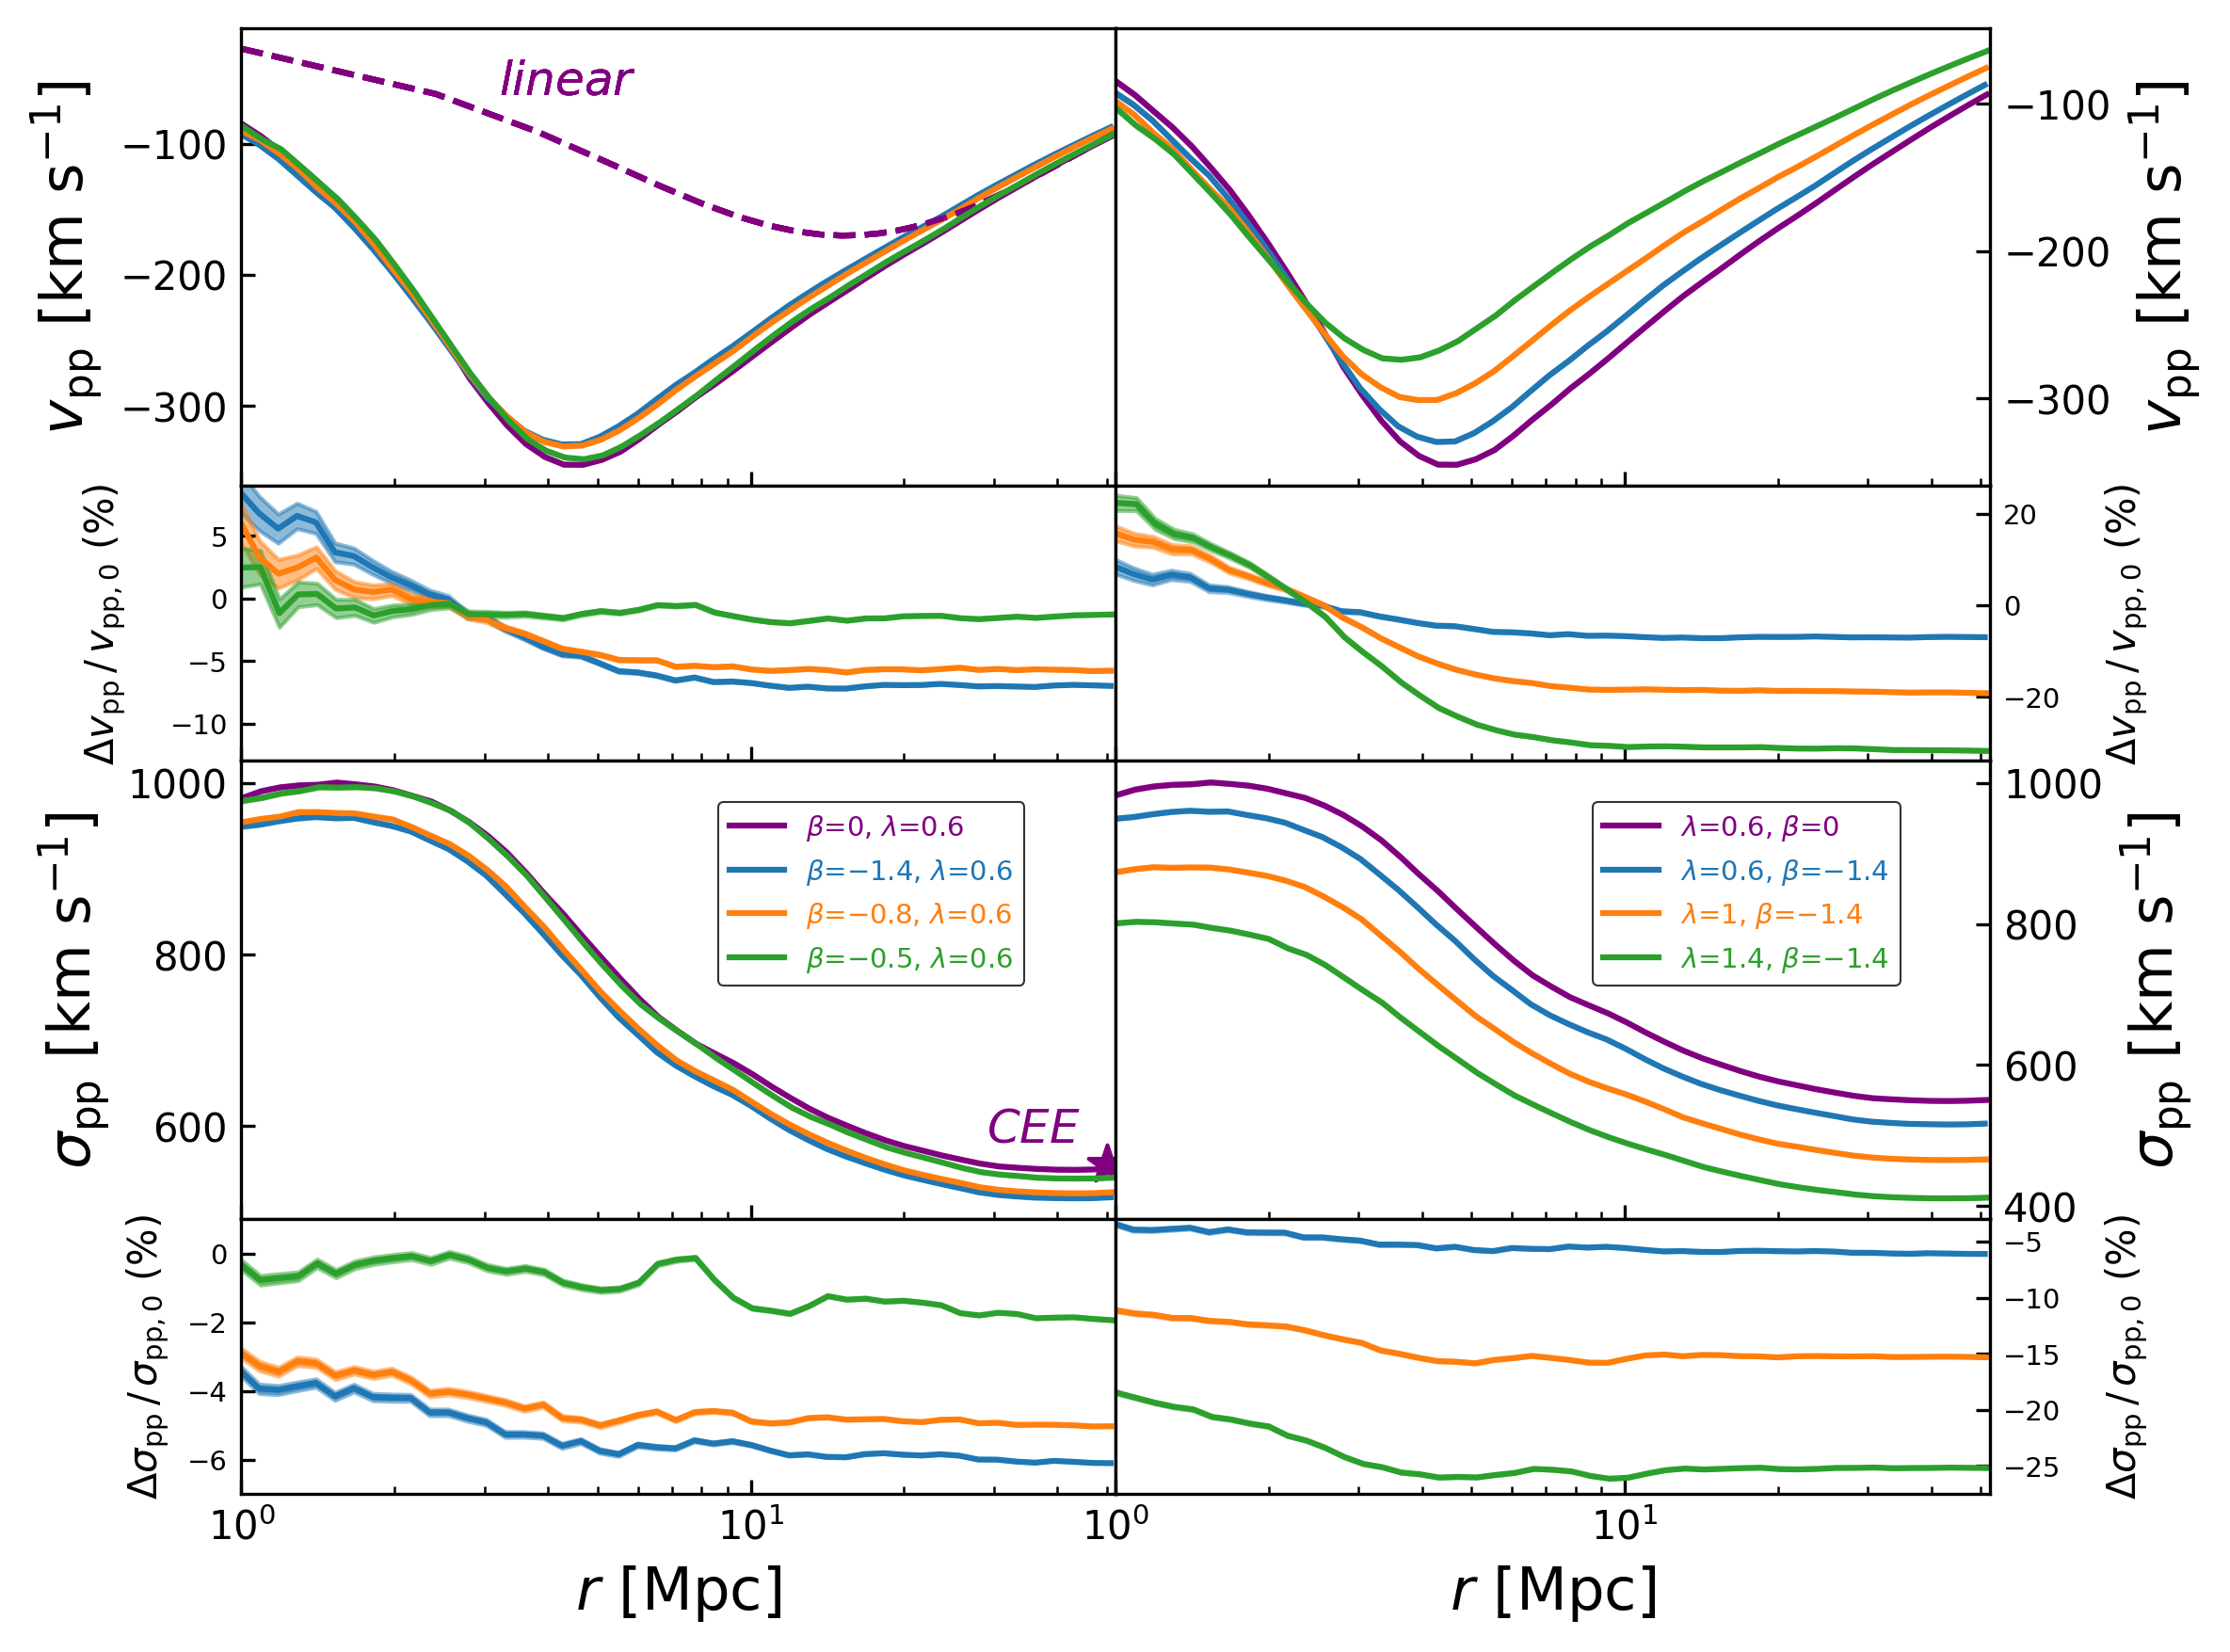

In [134]:
choice_v = vel_type[0]

#m_halo = halo_mass[0]
fig = plt.figure(figsize=(8, 6), dpi=300)
gs = GridSpec(4, 2, height_ratios=[2, 1.2, 2, 1.2])  # 3:1 height ratio (upper:lower)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0], sharex=ax1)
ax3 = fig.add_subplot(gs[2,0], sharex=ax1)
ax4 = fig.add_subplot(gs[3,0], sharex=ax1)
ax5 = fig.add_subplot(gs[0,1])
ax6 = fig.add_subplot(gs[1,1], sharex=ax1)
ax7 = fig.add_subplot(gs[2,1], sharex=ax1)
ax8 = fig.add_subplot(gs[3,1], sharex=ax1)

# # Create plots for different quantities
plot_all_curves(choice_v, None, v12_los_index, v12_los_error_index, "v", "\\beta", ax=ax1, show_plot=False)
plot_all_curves(choice_v, None, v12_los_index, v12_los_error_index, "v_ratio", "\\beta", ax=ax2, show_plot=False)
plot_all_curves(choice_v, None, v12_tot_index, v12_tot_error_index, "\\sigma", "\\beta", ax=ax3, show_plot=False)
plot_all_curves(choice_v, None, v12_tot_index, v12_tot_error_index, "sigma_ratio","\\beta", ax=ax4, show_plot=False)
plot_all_curves(choice_v, None, v12_los_index, v12_los_error_index, "v", "\\lambda", ax=ax5, show_plot=False)
plot_all_curves(choice_v, None, v12_los_index, v12_los_error_index, "v_ratio", "\\lambda", ax=ax6, show_plot=False)
plot_all_curves(choice_v, None, v12_tot_index, v12_tot_error_index, "\\sigma", "\\lambda", ax=ax7, show_plot=False)
plot_all_curves(choice_v, None, v12_tot_index, v12_tot_error_index, "sigma_ratio","\\lambda", ax=ax8, show_plot=False)

for ax in [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]:
    ax.tick_params(axis='y', direction='in') 
for ax in [ax5, ax6, ax7, ax8]:
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right() 
for ax in [ax2, ax4, ax6, ax8]:
    ax.tick_params(axis='y', labelsize=7)
    #ax.axhline(0, color='black', linestyle='--', linewidth=1)  

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(hspace=0, wspace=0)  # Set to zero for no space between subplots

# Adjust x-tick parameters
for ax in [ax1, ax2, ax3, ax5, ax6, ax7]:
    ax.tick_params(axis='x', which='both', direction='in', labelbottom=False)

ax4.tick_params(axis='x', which='both', direction='in') 
ax8.tick_params(axis='x', which='both', direction='in') 

for ax in [ax1, ax2, ax4, ax5, ax6, ax8]:
    ax.get_legend().remove()

ax2.set_ylim(-13, 9)  # 0.95 0.8

ax4.set_ylim(-7, 1)  # 0.95 0.8
ax6.set_ylim(-34, 26)  # 0.95 0.8
ax8.set_ylim(-27.5, -3)  # 0.95 0.8

ax3.legend(labelcolor = TABLEAU_COLORS, fontsize=7,  bbox_to_anchor=(0.53, 0.48), edgecolor='black')

#ax3.text(23.9, 880, '$\\lambda={}$'.format(velocity_choice(choice_v, '')[4]['-5e-1_A1']['\\lambda']), fontsize=9, ha='center', va='center')
#ax3.set_ylim(450, 1350)
# ax1.set_ylabel(r'$\frac{v_{pp}}{Hr\,\Omega_m^{0.55}}$', fontsize=15)
# ax5.set_ylabel(r'$\frac{v_{pp}}{Hr\,\Omega_m^{0.55}}$', fontsize=15)

# ax3.set_ylabel(r'$\frac{\sigma_{pp}}{Hr\,\Omega_m^{0.55}}}$', fontsize=15)
# ax7.set_ylabel(r'$\frac{\sigma_{pp}}{Hr\,\Omega_m^{0.55}}}$', fontsize=15)

ax7.legend(labelcolor = TABLEAU_COLORS, fontsize=7, bbox_to_anchor=(0.53, 0.48), edgecolor='black' )

#ax7.text(25, 880, '$\\beta={}$'.format(velocity_choice(choice_v, '')[4]['-5e-1_A1']['\\beta']), fontsize=9, ha='center', va='center')
#ax7.set_ylim(450, 1350)
ax8.set_ylabel('$\\Delta$' + '$\\sigma$' + '$_{\mathrm{pp}}$' + '$\,/\,\\sigma$' + '$_{\mathrm{pp,0}}$ (%)', fontsize=10)
ax2.yaxis.set_label_coords(-0.13, 0.5) 
ax6.yaxis.set_label_coords(1.13, 0.5)  
ax8.yaxis.set_label_coords(1.13, 0.5)  

for ax in [ax3, ax7]:  # Ensure the legend exists
    leg = ax.get_legend()
    leg.get_frame().set_linewidth(0.5)
# Save or show the combined figure
plt.savefig(r'/Users/kinho123/Downloads/mphil_project/pwv/vel_pp_DESI.pdf', bbox_inches='tight')
plt.show()

## Halo-halo case

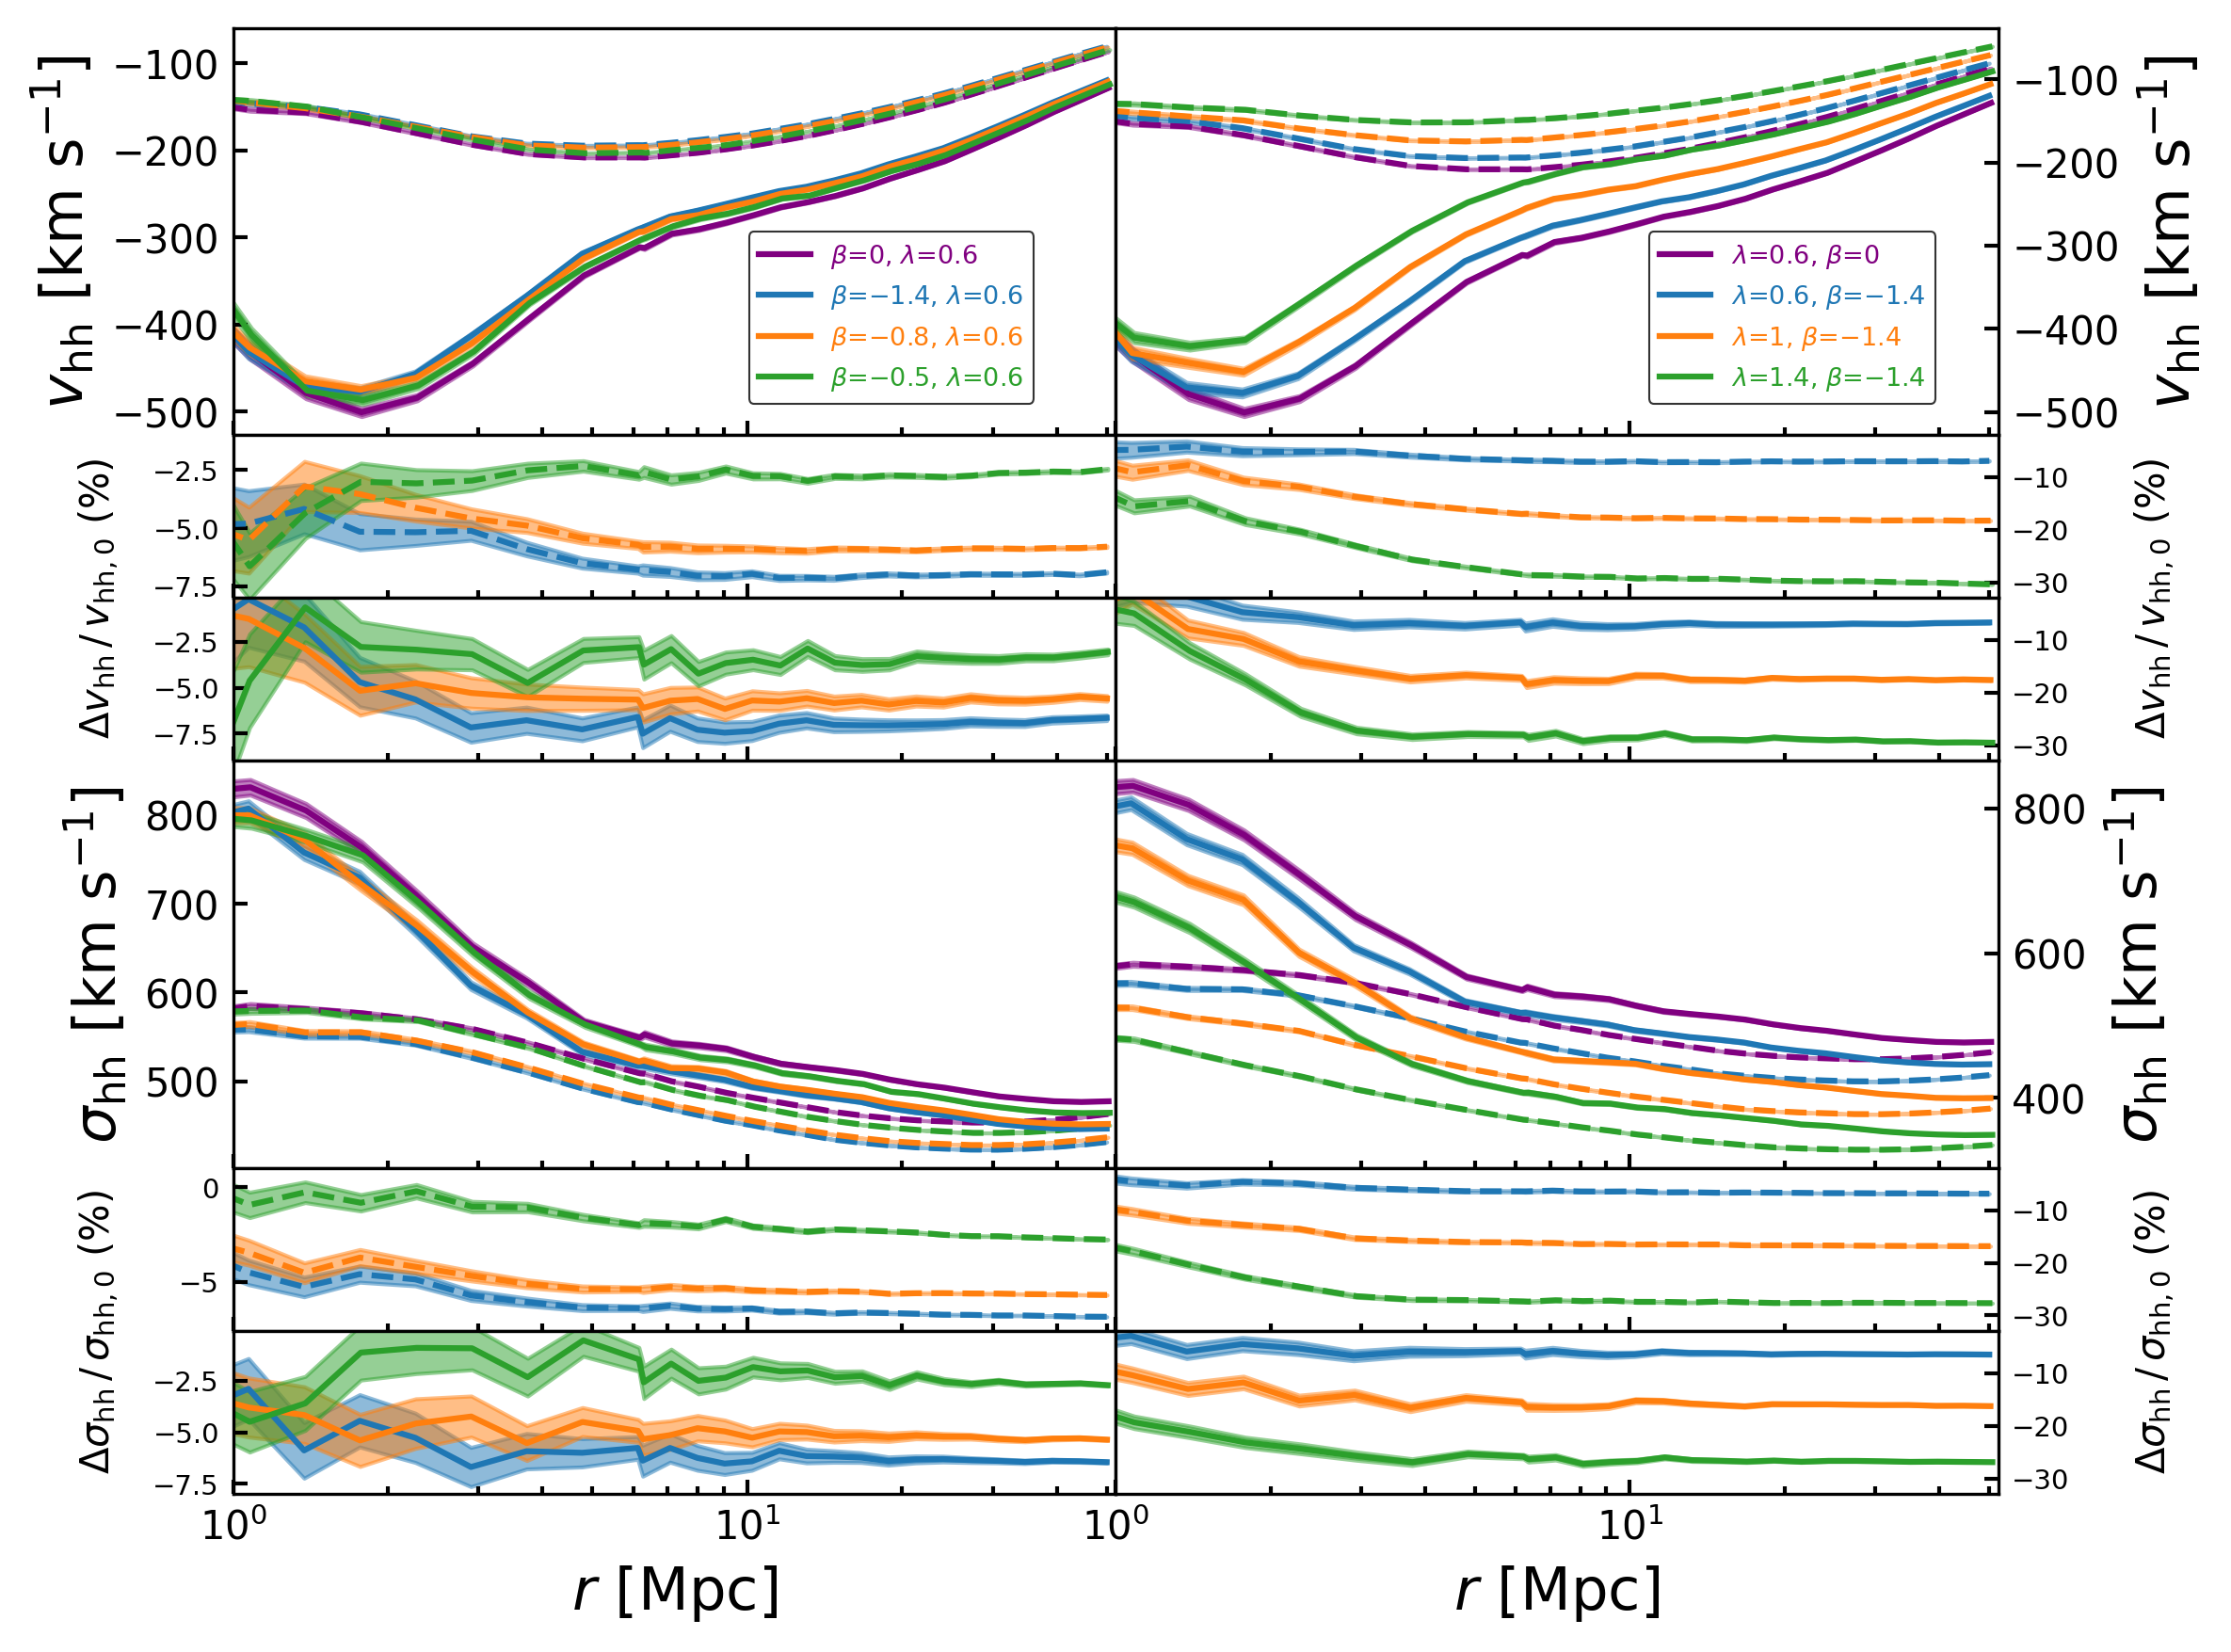

In [132]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

choice_v = vel_type[1]
mhalo_light = halo_mass[0]
mhalo_heavy = halo_mass[1]
fig = plt.figure(figsize=(8, 6), dpi=300)
gs = GridSpec(6, 2, height_ratios=[2, 0.8, 0.8, 2, 0.8, 0.8])  # 3:1 height ratio (upper:lower)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0], sharex=ax1)
ax3 = fig.add_subplot(gs[2,0], sharex=ax1)
ax4 = fig.add_subplot(gs[3,0], sharex=ax1)
ax5 = fig.add_subplot(gs[4,0], sharex=ax1)
ax6 = fig.add_subplot(gs[5,0], sharex=ax1)
ax7 = fig.add_subplot(gs[0,1])
ax8 = fig.add_subplot(gs[1,1], sharex=ax1)
ax9 = fig.add_subplot(gs[2,1], sharex=ax1)
ax10 = fig.add_subplot(gs[3,1], sharex=ax1)
ax11 = fig.add_subplot(gs[4,1], sharex=ax1)
ax12 = fig.add_subplot(gs[5,1], sharex=ax1)

# # Create plots for different quantities
plot_all_curves(choice_v, mhalo_light, v12_los_index, v12_los_error_index, "v", "\\beta", ax=ax1, show_plot=False)
plot_all_curves(choice_v, mhalo_heavy, v12_los_index, v12_los_error_index, "v", "\\beta", ax=ax1, show_plot=False)
plot_all_curves(choice_v, mhalo_light, v12_los_index, v12_los_error_index, "v_ratio", "\\beta", ax=ax2, show_plot=False)
plot_all_curves(choice_v, mhalo_heavy, v12_los_index, v12_los_error_index, "v_ratio", "\\beta", ax=ax3, show_plot=False)
plot_all_curves(choice_v, mhalo_light, v12_tot_index, v12_tot_error_index, "\\sigma", "\\beta", ax=ax4, show_plot=False)

plot_all_curves(choice_v, mhalo_heavy, v12_tot_index, v12_tot_error_index, "\\sigma", "\\beta", ax=ax4, show_plot=False)
plot_all_curves(choice_v, mhalo_light, v12_tot_index, v12_tot_error_index, "sigma_ratio","\\beta", ax=ax5, show_plot=False)
plot_all_curves(choice_v, mhalo_heavy, v12_tot_index, v12_tot_error_index, "sigma_ratio","\\beta", ax=ax6, show_plot=False)
plot_all_curves(choice_v, mhalo_light, v12_los_index, v12_los_error_index, "v", "\\lambda", ax=ax7, show_plot=False)
plot_all_curves(choice_v, mhalo_heavy, v12_los_index, v12_los_error_index, "v", "\\lambda", ax=ax7, show_plot=False)
plot_all_curves(choice_v, mhalo_light, v12_los_index, v12_los_error_index, "v_ratio", "\\lambda", ax=ax8, show_plot=False)
plot_all_curves(choice_v, mhalo_heavy, v12_los_index, v12_los_error_index, "v_ratio", "\\lambda", ax=ax9, show_plot=False)
plot_all_curves(choice_v, mhalo_light, v12_tot_index, v12_tot_error_index, "\\sigma", "\\lambda", ax=ax10, show_plot=False)
plot_all_curves(choice_v, mhalo_heavy, v12_tot_index, v12_tot_error_index, "\\sigma", "\\lambda", ax=ax10, show_plot=False)
plot_all_curves(choice_v, mhalo_light, v12_tot_index, v12_tot_error_index, "sigma_ratio","\\lambda", ax=ax11, show_plot=False)
plot_all_curves(choice_v, mhalo_heavy, v12_tot_index, v12_tot_error_index, "sigma_ratio","\\lambda", ax=ax12, show_plot=False)

for ax in [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12]:
    ax.tick_params(axis='y', direction='in', width=1) 
for ax in [ax7, ax8, ax9, ax10, ax11, ax12]:
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right() 
# Adjust layout
plt.tight_layout()
plt.subplots_adjust(hspace=0, wspace=0)  # Set to zero for no space between subplots

# Adjust x-tick parameters
for ax in [ax1, ax2, ax3, ax4, ax5, ax7, ax8, ax9, ax10, ax11]:
    ax.tick_params(axis='x', which='both', direction='in', labelbottom=False, width=1)
ax6.tick_params(axis='x', which='both', direction='in', width=1) 
ax12.tick_params(axis='x', which='both', direction='in', width=1) 


for ax in [ax2, ax3, ax4, ax5, ax6, ax8, ax9, ax11, ax10, ax12]:
    ax.get_legend().remove()

for ax in [ax2, ax3, ax5, ax6, ax8, ax9, ax11, ax12]:
    ax.set_ylabel('')
    ax.tick_params(axis='y', labelsize=7)

# Add common y-label
pos_ax2 = ax2.get_position()
pos_ax3 = ax3.get_position()
pos_ax5 = ax5.get_position()
pos_ax6 = ax6.get_position()

pos_ax8 = ax8.get_position()
pos_ax9 = ax9.get_position()
pos_ax11 = ax11.get_position()
pos_ax12 = ax12.get_position()

fig.text(0.04, (pos_ax2.y0 + pos_ax3.y1) / 2, '$\\Delta v_{\mathrm{hh}} \,/ \, v_{\mathrm{hh,0}}$ (%)',  # Example label
         va='center', rotation='vertical', fontsize=10)
fig.text(0.04, (pos_ax5.y0 + pos_ax6.y1) / 2, '$\\Delta \\sigma_{\mathrm{hh}} \,/ \, \\sigma_{\mathrm{hh,0}}$ (%)',  # Example label
         va='center', rotation='vertical', fontsize=10)
fig.text(0.95, (pos_ax2.y0 + pos_ax3.y1) / 2, '$\\Delta v_{\mathrm{hh}} \,/ \, v_{\mathrm{hh,0}}$ (%)',  # Example label
         va='center', rotation='vertical', fontsize=10)
fig.text(0.95, (pos_ax5.y0 + pos_ax6.y1) / 2, '$\\Delta \\sigma_{\mathrm{hh}} \,/ \, \\sigma_{\mathrm{hh,0}}$ (%)',  # Example label
         va='center', rotation='vertical', fontsize=10)
 
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[4:], labels[0:], labelcolor = TABLEAU_COLORS[0:], fontsize=6.5, bbox_to_anchor=(0.57, 0.53), edgecolor='black')
#ax1.text(23, -290, '$\\lambda={}$'.format(velocity_choice(choice_v, '')[4]['A1']['\\lambda']), fontsize=9, ha='center', va='center')
#ax1.set_ylim(-530, -70)
ax2.set_ylim(-8,  -1)
ax3.set_ylim(-9, -0.1)
#ax4.set_ylim(360, 830)
ax5.set_ylim(-7.6, 1)
ax6.set_ylim(-8, -0.1)

handles, labels = ax7.get_legend_handles_labels()
ax7.legend(handles[4:], labels[0:], labelcolor = TABLEAU_COLORS[0:], fontsize=6.5, bbox_to_anchor=(0.59, 0.53), edgecolor='black')
#ax7.text(23, -271, '$\\beta={}$'.format(velocity_choice(choice_v, '')[4]['A2']['\\beta']), fontsize=9, ha='center', va='center')
#ax7.set_ylim(-550, -50)
ax8.set_ylim(-33, -2)
ax9.set_ylim(-33, -2)
ax11.set_ylim(-33, -2)
ax12.set_ylim(-33, -2)

for ax in [ax1, ax7]:  # Ensure the legend exists
    leg = ax.get_legend()
    leg.get_frame().set_linewidth(0.5)

# Save or show the combined figure
#plt.savefig(r'/Users/kinho123/Downloads/mphil_project/pwv/vel_hh_DESI.pdf', bbox_inches='tight')
plt.show()

[[-0.05028399 -0.16022305 -0.27920706]
 [-0.03979238 -0.1357978  -0.24665389]
 [ 0.         -0.11288293 -0.20548523]] [[0.00227441 0.00477272 0.00692322]
 [0.00160613 0.00457995 0.006544  ]
 [0.         0.00432794 0.00752749]]
[[-0.03295406 -0.10733898 -0.18281022]
 [-0.02632936 -0.09184054 -0.16007194]
 [ 0.         -0.07880873 -0.13857249]] [[0.000452   0.00179544 0.00322524]
 [0.00062567 0.00143907 0.00293526]
 [0.         0.00134143 0.00259767]]

Regression Results for $\Delta R^{v}_{\mathrm{p1}} \,\, (\%)$:
c1 = 6.440 ± 0.812 (%)
c2 = -27.329 ± 0.861 (%)
R-squared = 0.99650

Regression Results for $\Delta R^{\sigma}_{\mathrm{p2}} \,\, (\%)$:
c1 = 5.554 ± 0.637 (%)
c2 = -23.061 ± 0.676 (%)
R-squared = 0.99699

Regression Results for $\Delta R^{v}_{\mathrm{h2}} \,\, (\%)$:
c1 = 6.107 ± 0.709 (%)
c2 = -27.553 ± 0.752 (%)
R-squared = 0.99733

Regression Results for $\Delta R^{\sigma}_{\mathrm{h2}} \,\, (\%)$:
c1 = 5.466 ± 0.682 (%)
c2 = -23.718 ± 0.724 (%)
R-squared = 0.99670


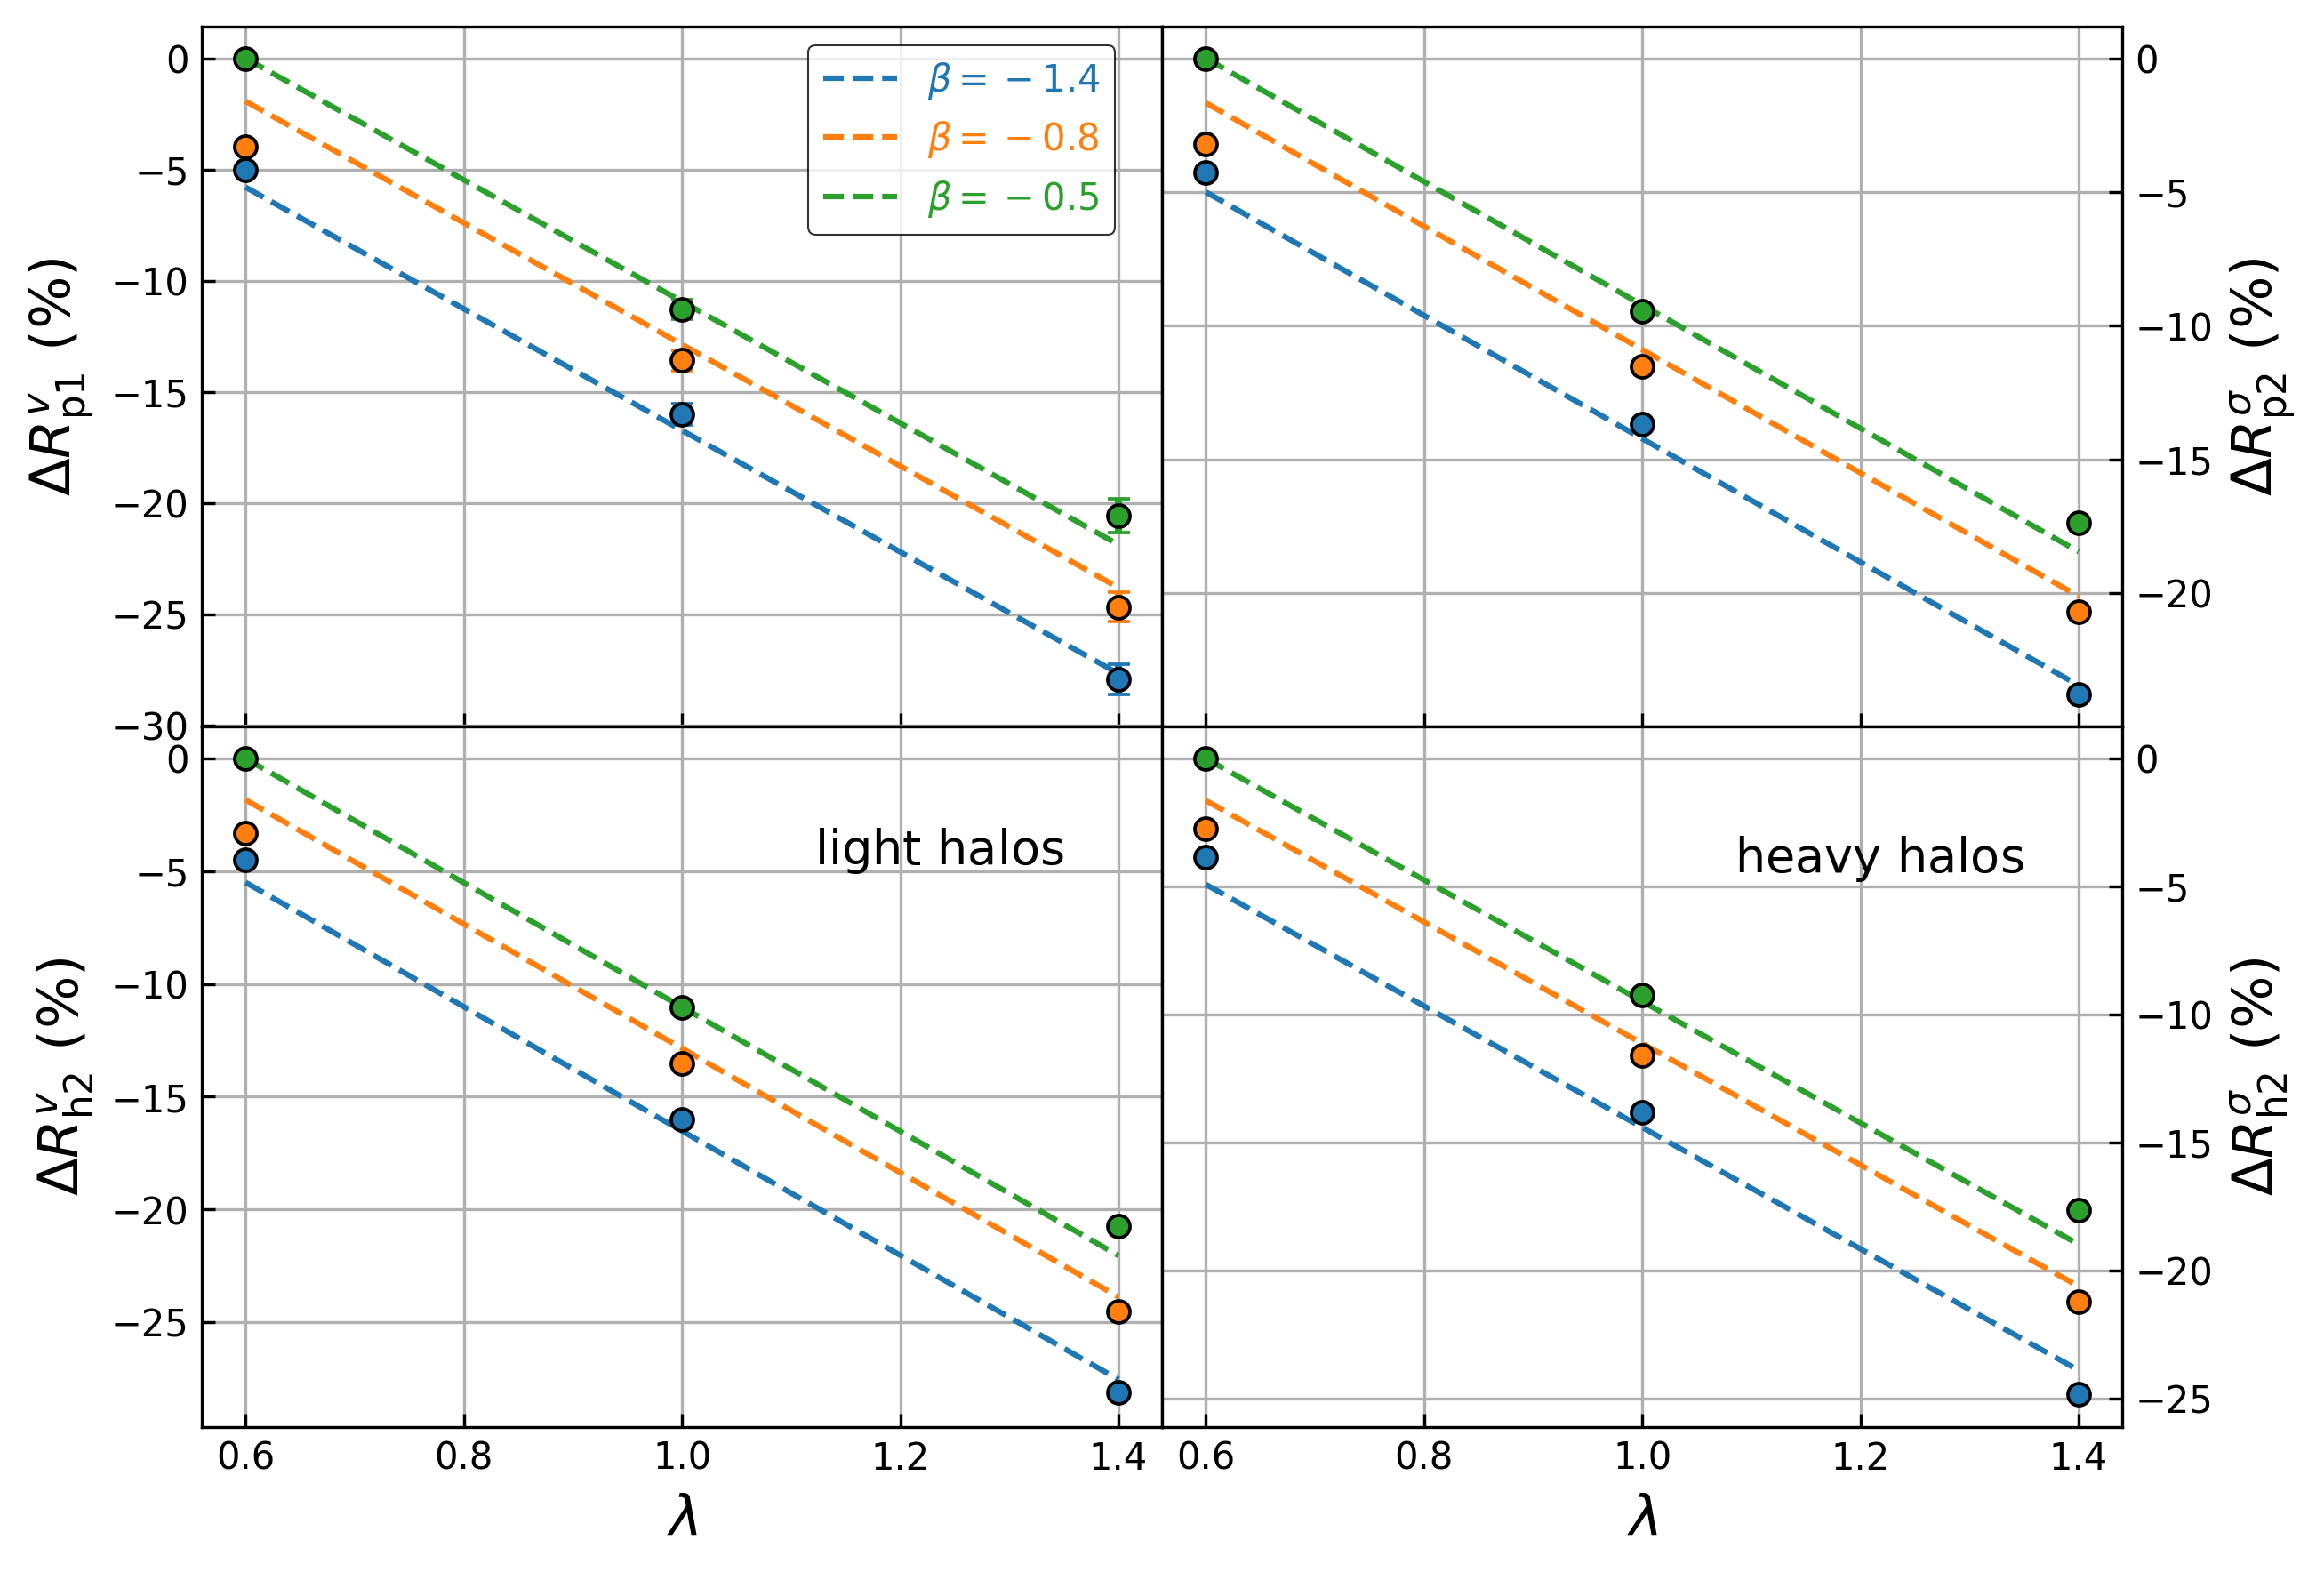

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import statsmodels.api as sm

# Data

mean_deviations_v_pp = plot_all_curves(vel_type[0] , '', v12_los_index, v12_los_error_index, "v_ratio", "\\beta", ax=None, show_plot=False) 
print(mean_deviations_v_pp[0], mean_deviations_v_pp[3])
mean_deviations_sigma_pp = plot_all_curves(vel_type[0], '', v12_tot_index, v12_tot_error_index, "sigma_ratio", "\\beta", ax=None, show_plot=False) 
print(mean_deviations_sigma_pp[2], mean_deviations_sigma_pp[5])

mean_deviations_v_hh = plot_all_curves(vel_type[1] , halo_mass[0], v12_los_index, v12_los_error_index, "v_ratio", "\\beta", ax=None, show_plot=False) 
#print(mean_deviations_v_hh[0], mean_deviations_v_hh[2])
mean_deviations_sigma_hh = plot_all_curves(vel_type[1], halo_mass[1], v12_tot_index, v12_tot_error_index, "sigma_ratio", "\\beta", ax=None, show_plot=False) 
#print(mean_deviations_sigma_hh[1], mean_deviations_sigma_hh[3])

Lambda = np.array([0.6, 1, 1.4])
beta = np.array([-1.4, -0.8, -0.5])
num_colors = len(beta)
colors = TABLEAU_COLORS[1:num_colors+1] 
Lambda_ref = 0.6
beta_ref = -0.5

# Function to plot mean ratios with error bars
def plot_mean_deviations(deviations, errors, ylabel, choice, ax=None):
    global c1, c2, intercept

    # Prepare data for fitting
    X = np.array([[(beta_val - beta_ref), (lambda_val - Lambda_ref) ] 
               for beta_val in beta for lambda_val in Lambda])
    y = deviations.flatten()

    # Add intercept term to X
    #X = sm.add_constant(X)  # Adds a column of ones for the intercept
    # Fit linear regression model
    model = sm.OLS(y, X).fit()
    # Extract coefficients and errors
    #intercept = model.params[0]
    #intercept_err = model.bse[0]

    c1, c2 = model.params  # Adjust to extract all four coefficients
    c1_err, c2_err = model.bse  # Adjust indexing

    
    # Print results
    print(f"\nRegression Results for {ylabel}:")
    print(f"c1 = {c1 * 1e2:.3f} ± {c1_err * 1e2:.3f} (%)")
    print(f"c2 = {c2 * 1e2:.3f} ± {c2_err * 1e2:.3f} (%)")
    #print(f"c3 = {c3 * 1e2:.3f} ± {c3_err * 1e2:.3f} (%)")
    #print(f"c4 = {c4 * 1e2:.3f} ± {c4_err * 1e2:.3f} (%)")
    print(f"R-squared = {model.rsquared:.5f}")
    # If no axis is provided, create a new figure
    if ax is None:
        fig, ax = plt.subplots(figsize=(9, 3), dpi=300)
    #c3 * (beta[i])**2) * 1e2
    #c3 * (beta)**2) * 1e2
    for i, color in enumerate(colors):
        if choice == "vary_beta":
            # Plot with error bars for fixed beta
            ax.errorbar(Lambda, (deviations[i]) * 1e2, yerr=(errors[i]) * 1e2, fmt='o', color=color, ecolor=color, elinewidth=2, capsize=3, capthick=5, markeredgewidth=0.9, markeredgecolor='black')
            ax.plot(Lambda,  (c1 * (beta[i] - beta_ref) + c2 * (Lambda - Lambda_ref) ) * 1e2, color=color, linestyle='dashed', label=f'$\\beta={beta[i]}$')
            ax.set_xlabel('$\lambda$', fontsize=15)
        else:
            # Plot with error bars for fixed lambda
            ax.errorbar(beta, (deviations[:, i]) * 1e2, yerr=(errors[:, i]) * 1e2, fmt='o', color=color, ecolor=color, elinewidth=2, capsize=3, capthick=1.5, markeredgecolor='black', markeredgewidth=0.35)
            ax.plot(beta, (  c1 * (beta[i] - beta_ref) + c2 * (Lambda - Lambda_ref)  ) * 1e2  , color=color, linestyle='dashed', label=f'$\\lambda={Lambda[i]}$')
            ax.set_xlabel('$\\beta$', fontsize=15)

    ax.set_ylabel(ylabel, fontsize=15)
    ax.grid(True)
    ax.legend(labelcolor = colors, fontsize=10, edgecolor='black', bbox_to_anchor=(0.97, 1))
    leg = ax.get_legend()
    leg.get_frame().set_linewidth(0.5)

fig = plt.figure(figsize=(9, 7), dpi=300)
gs = fig.add_gridspec(2, 2, wspace=0)  # Set wspace=0 for zero horizontal spacing
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])  # Share y-axis if appropriate
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])

for ax in [ax1, ax2, ax3, ax4]:
    ax.tick_params(axis='x', direction='in') 
    ax.tick_params(axis='y', direction='in') 
# Plot the data
plot_mean_deviations(mean_deviations_v_pp[0], mean_deviations_v_pp[3], '$\Delta R^{v}_{\mathrm{p1}} \,\, (\%)$', "vary_beta", ax=ax1)
plot_mean_deviations(mean_deviations_sigma_pp[1], mean_deviations_sigma_pp[4], '$\Delta R^{\\sigma}_{\mathrm{p2}} \,\, (\%)$', "vary_beta", ax=ax2)
plot_mean_deviations(mean_deviations_v_hh[1], mean_deviations_v_hh[4], '$\Delta R^{v}_{\mathrm{h2}} \,\, (\%)$', "vary_beta", ax=ax3)
plot_mean_deviations(mean_deviations_sigma_hh[1], mean_deviations_sigma_hh[4], '$\Delta R^{\\sigma}_{\mathrm{h2}} \,\, (\%)$', "vary_beta", ax=ax4)


# Adjust axis elements
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax4.yaxis.set_label_position("right")
ax4.yaxis.tick_right()
ax2.get_legend().remove()
ax3.get_legend().remove()
ax4.get_legend().remove()
#ax1.set_ylim(-15.9, 22)

#ax2.set_ylim(-15.9, 22)
#ax3.set_ylim(-15.9, 22)
#ax4.set_ylim(-15.9, 22)

ax3.text(1.35, -4.1, '$\mathrm{light \,\, halos}$', fontsize=13, ha='right', va='center')

ax4.text(1.35, -3.9, '$\mathrm{heavy \,\, halos}$', fontsize=13, ha='right', va='center')


#ax1.text(0, 0, '', fontsize=12, ha='center', va='center')
#ax2.text(0, 0, '$\\beta={}$'.format(velocity_choice(choice_v, '')[4]['A2']['\\beta']), fontsize=12, ha='center', va='center')



# Remove padding around plots
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.15, wspace=0,  hspace=0)
plt.savefig(r'/Users/kinho123/Downloads/mphil_project/pwv/deviations_DESI.pdf', bbox_inches='tight')
plt.show()

In [29]:
mean_deviations_v_pp = plot_all_curves(vel_type[0] , '', v12_los_index, v12_los_error_index, "v_ratio", "\\beta", ax=None, show_plot=False) 
print(mean_deviations_v_pp[0], mean_deviations_v_pp[3])
mean_deviations_sigma_pp = plot_all_curves(vel_type[0], '', v12_tot_index, v12_tot_error_index, "sigma_ratio", "\\beta", ax=None, show_plot=False) 
print(mean_deviations_sigma_pp[2], mean_deviations_sigma_pp[5])

mean_deviations_v_hh = plot_all_curves(vel_type[1] , halo_mass[1], v12_los_index, v12_los_error_index, "v_ratio", "\\beta", ax=None, show_plot=False) 
#print(mean_deviations_v_hh[0], mean_deviations_v_hh[2])
mean_deviations_sigma_hh = plot_all_curves(vel_type[1], halo_mass[1], v12_tot_index, v12_tot_error_index, "sigma_ratio", "\\beta", ax=None, show_plot=False) 
#print(mean_deviations_sigma_hh[1], mean_deviations_sigma_hh[3])


# Function to plot mean ratios with error bars
def mean_deviations(deviations, errors, ylabel, choice):
    global c1, c2, intercept

    # Prepare data for fitting
    X = np.array([[(beta_val - beta_ref), (lambda_val - Lambda_ref) ] 
               for beta_val in beta for lambda_val in Lambda])
    y = deviations.flatten()

    # Add intercept term to X
    #X = sm.add_constant(X)  # Adds a column of ones for the intercept
    # Fit linear regression model
    model = sm.OLS(y, X).fit()
    # Extract coefficients and errors
    #intercept = model.params[0]
    #intercept_err = model.bse[0]

    c1, c2 = model.params  # Adjust to extract all four coefficients
    c1_err, c2_err = model.bse  # Adjust indexing

    
    # Print results
    print(f"\nRegression Results for {ylabel}:")
    print(f"c1 = {c1 * 1e2:.3f} ± {c1_err * 1e2:.3f} (%)")
    print(f"c2 = {c2 * 1e2:.3f} ± {c2_err * 1e2:.3f} (%)")
    #print(f"c3 = {c3 * 1e2:.3f} ± {c3_err * 1e2:.3f} (%)")
    #print(f"c4 = {c4 * 1e2:.3f} ± {c4_err * 1e2:.3f} (%)")
    print(f"R-squared = {model.rsquared:.5f}")
    
mean_deviations(mean_deviations_v_pp[1], mean_deviations_v_pp[4], '$\Delta R^{v}_{\mathrm{p1}} \,\, (\%)$', "vary_beta")
mean_deviations(mean_deviations_sigma_pp[1], mean_deviations_sigma_pp[4], '$\Delta R^{\\sigma}_{\mathrm{p2}} \,\, (\%)$', "vary_beta")
mean_deviations(mean_deviations_v_hh[0+1], mean_deviations_v_hh[3+1], '$\Delta R^{v}_{\mathrm{h2}} \,\, (\%)$', "vary_beta")
mean_deviations(mean_deviations_sigma_hh[0+1], mean_deviations_sigma_hh[3+1], '$\Delta R^{\\sigma}_{\mathrm{h2}} \,\, (\%)$', "vary_beta")

[[-0.05028399 -0.16022305 -0.27920706]
 [-0.03979238 -0.1357978  -0.24665389]
 [ 0.         -0.11288293 -0.20548523]] [[0.00227441 0.00477272 0.00692322]
 [0.00160613 0.00457995 0.006544  ]
 [0.         0.00432794 0.00752749]]
[[-0.03295406 -0.10733898 -0.18281022]
 [-0.02632936 -0.09184054 -0.16007194]
 [ 0.         -0.07880873 -0.13857249]] [[0.000452   0.00179544 0.00322524]
 [0.00062567 0.00143907 0.00293526]
 [0.         0.00134143 0.00259767]]

Regression Results for $\Delta R^{v}_{\mathrm{p1}} \,\, (\%)$:
c1 = 6.814 ± 0.804 (%)
c2 = -30.573 ± 0.853 (%)
R-squared = 0.99721

Regression Results for $\Delta R^{\sigma}_{\mathrm{p2}} \,\, (\%)$:
c1 = 5.554 ± 0.637 (%)
c2 = -23.061 ± 0.676 (%)
R-squared = 0.99699

Regression Results for $\Delta R^{v}_{\mathrm{h2}} \,\, (\%)$:
c1 = 5.306 ± 0.704 (%)
c2 = -26.068 ± 0.747 (%)
R-squared = 0.99698

Regression Results for $\Delta R^{\sigma}_{\mathrm{h2}} \,\, (\%)$:
c1 = 5.466 ± 0.682 (%)
c2 = -23.718 ± 0.724 (%)
R-squared = 0.99670


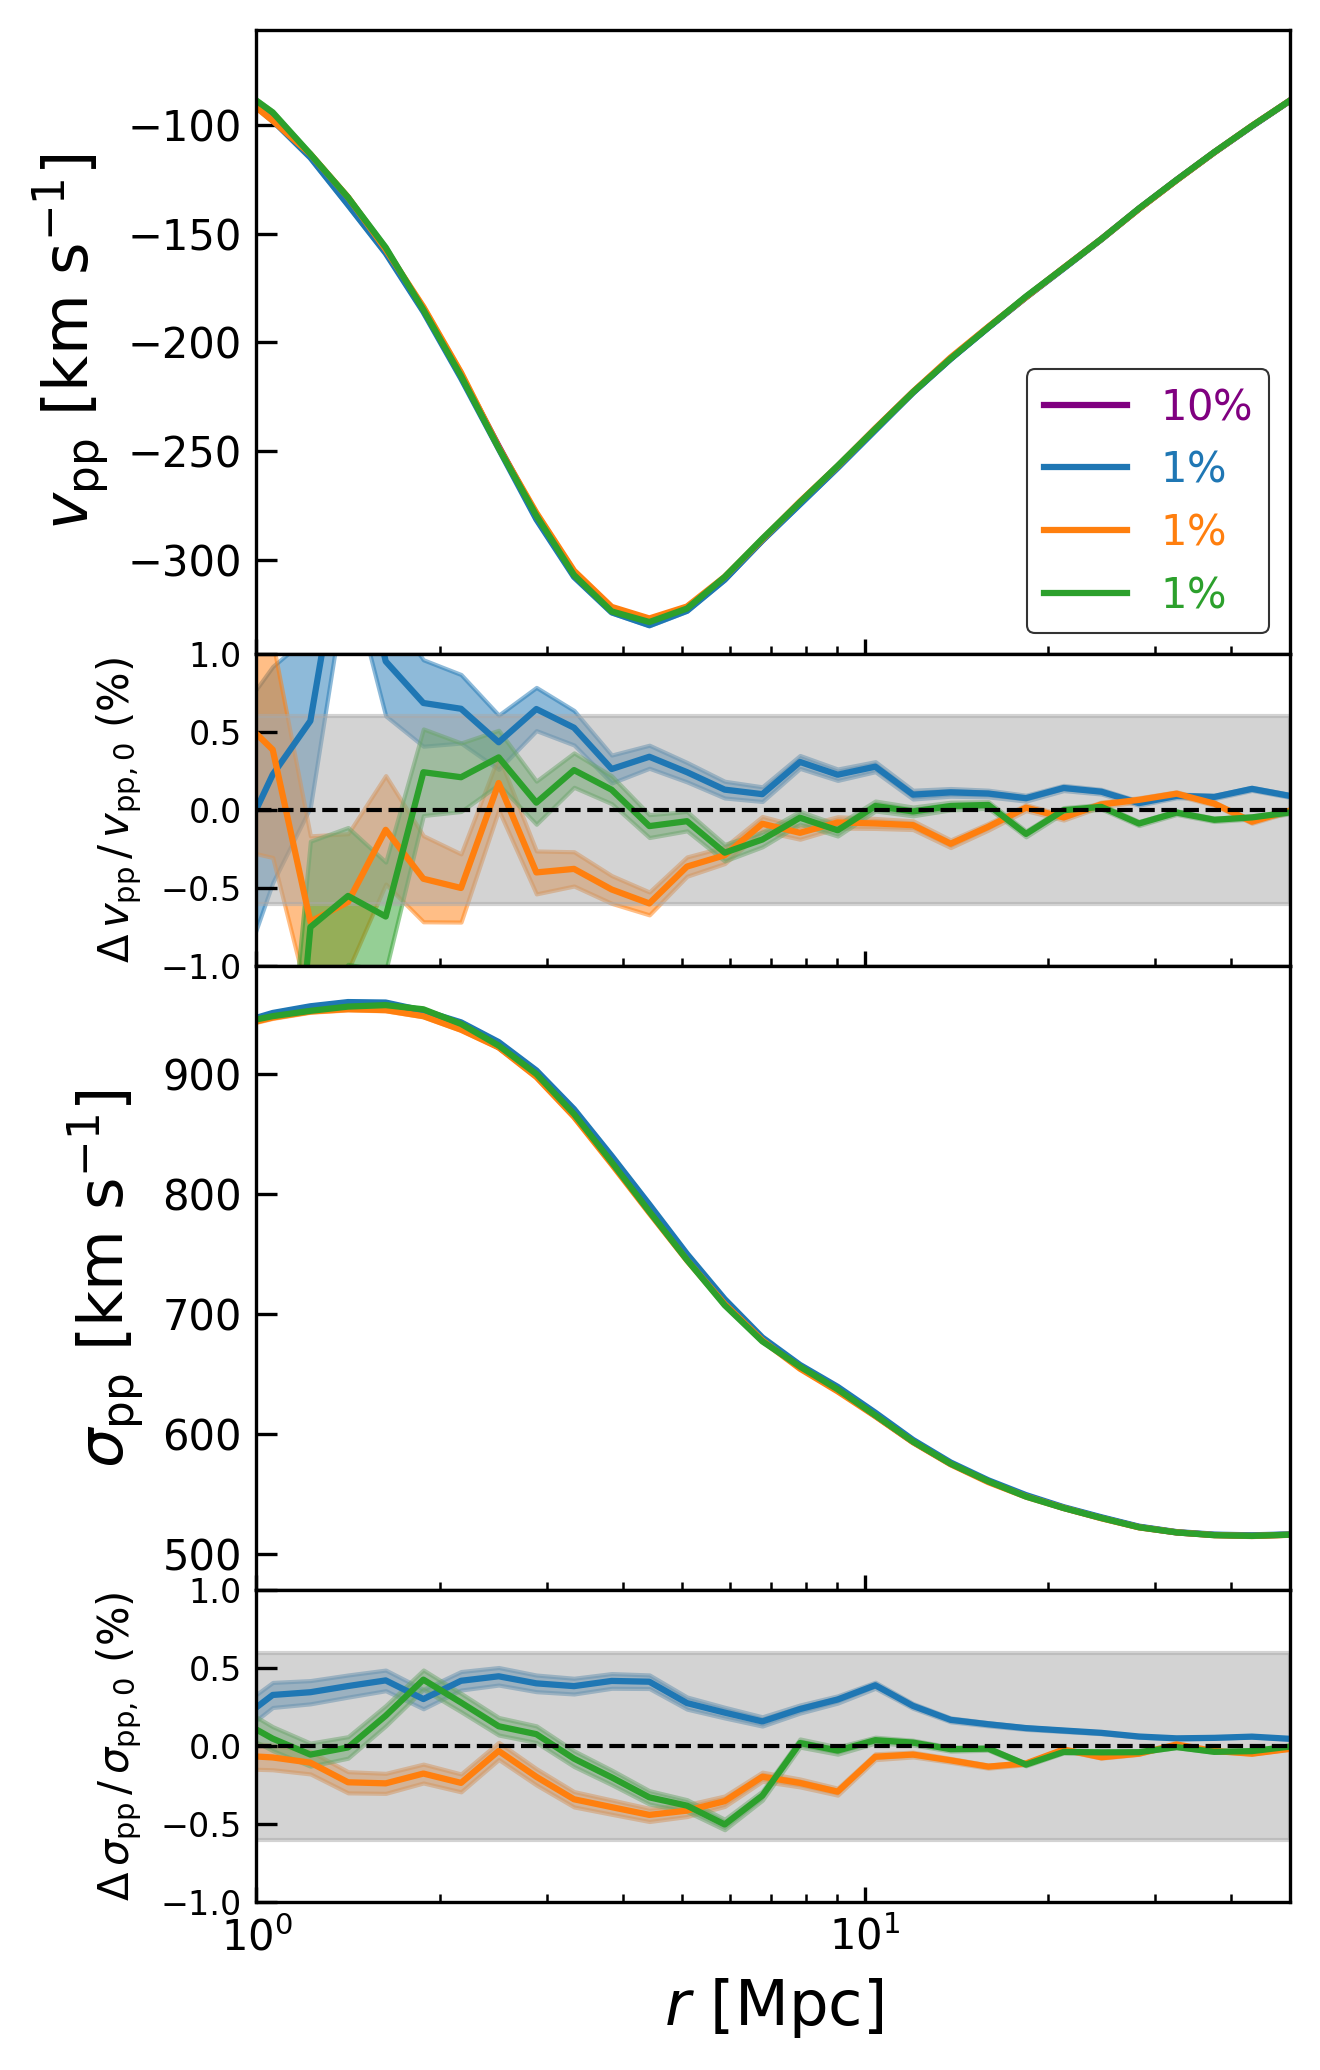

In [11]:
seed = [2018, 2018, 8102, 19222]
file_names = ['/Users/kinho123/Downloads/mphil_project/pwv/vpp_1024_DESI/type3_mom_-1.4e+0_A1_2018_fpart_0.10_r_0.50_36.00.txt']
file_names += ['/Users/kinho123/Downloads/mphil_project/pwv/vpp_1024_DESI/type3_mom_-1.4e+0_A1_{}_fpart_0.01_r_0.50_36.00.txt'.format(i) for i in seed[1:]]
# Labels for each file
labels = [r'{}'.format(i) for i in seed]

# Plot settings
font_size = 15
plot_xmin = 1
plot_xmax = 50

# Create a figure with gridspec
fig = plt.figure(figsize=(4.5, 7), dpi=300)
gs = fig.add_gridspec(4, 1, height_ratios=[2, 1, 2, 1])  # 2 rows, 1 column

# Create axes for v12_los and d_los, sharing x-axis
ax1 = fig.add_subplot(gs[0, 0])  # Top subplot for v12_los
ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)  # Bottom subplot for d_los
ax3 = fig.add_subplot(gs[2, 0], sharex=ax1)  # Bottom subplot for d_los
ax4 = fig.add_subplot(gs[3, 0], sharex=ax1)  # Bottom subplot for d_los

# Loop through each file and plot v12_los and d_los
for i, file_name in enumerate(file_names):
    radius, pair_number, v12_tot, v12_tot_error, v12_los, v12_los_error, v12_per, v12_per_error, d12_tot, d12_tot_error, d12_los, d12_los_error, d12_per, d12_per_error = np.loadtxt(file_name, skiprows=1, unpack=True)
    rad_mpc = radius / 0.6714593
    
    #ratio = quantity / quantity_ref
    
    #error_ratio = ratio*np.sqrt((error/quantity)**2 + (error_ref/quantity_ref)**2 )
    if file_name == file_names[0]:
        vpp_ref, vpp_ref_error = v12_los, v12_los_error
        sigmapp_ref, sigmapp_ref_error = d12_los, d12_los_error
    
    v_ratio, sigma_ratio = v12_los / vpp_ref, d12_los / sigmapp_ref 
    v_deviation, sigma_deviation = v_ratio - 1, sigma_ratio - 1
    v_error_ratio, sigma_error_ratio = v_ratio*np.sqrt((v12_los_error/v12_los)**2 + (vpp_ref_error/vpp_ref)**2 ), v_ratio*np.sqrt((d12_los_error/d12_los)**2 + (sigmapp_ref_error/sigmapp_ref)**2 )
    # Plot v12_los
    ax1.plot(rad_mpc, v12_los, color=TABLEAU_COLORS[i], label=labels[i])
    ax1.fill_between(rad_mpc, v12_los + v12_los_error, v12_los - v12_los_error, facecolor=TABLEAU_COLORS[i], edgecolor=TABLEAU_COLORS[i], alpha=0.5)
    
    # Plot d_los in the second subplot
    
    ax3.plot(rad_mpc, d12_los, color=TABLEAU_COLORS[i], label=labels[i])
    ax3.fill_between(rad_mpc, d12_los + d12_los_error, d12_los - d12_los_error, facecolor=TABLEAU_COLORS[i], edgecolor=TABLEAU_COLORS[i], alpha=0.5)
    
    if file_name != file_names[0]: 
        ax2.plot(rad_mpc, v_deviation*1e2 , color=TABLEAU_COLORS[i], label=labels[i])
        ax2.fill_between(rad_mpc, (v_deviation + v_error_ratio)*1e2, (v_deviation- v_error_ratio)*1e2, facecolor=TABLEAU_COLORS[i], edgecolor=TABLEAU_COLORS[i], alpha=0.5)
        ax4.plot(rad_mpc, sigma_deviation*1e2 , color=TABLEAU_COLORS[i], label=labels[i])
        ax4.fill_between(rad_mpc, (sigma_deviation + sigma_error_ratio)*1e2, (sigma_deviation- sigma_error_ratio)*1e2, facecolor=TABLEAU_COLORS[i], edgecolor=TABLEAU_COLORS[i], alpha=0.5)

legend = ax1.legend(fontsize=10, loc='lower right', edgecolor='black')
legend.get_frame().set_linewidth(0.5) 
# Change legend text color to match line colors
for i, text in enumerate(legend.get_texts()):
    if i == 0:
        text.set_text("$10 \%$") 
    else:
        text.set_text("$1 \%$")  # Example of customizing labels
    text.set_color(TABLEAU_COLORS[i])
    

ax1.set_ylabel('$v_{\mathrm{pp}} \,\, [\\mathrm{km}$ $\\mathrm{s}^{-1}]$', fontsize=font_size)
ax2.set_ylabel('$\Delta  \, v_{\mathrm{pp}} \, /\,v_{\mathrm{pp,0}}  \,\, (\%) $', fontsize=10)
ax3.set_ylabel('$\\sigma_{\mathrm{pp}} \,\, [\\mathrm{km}$ $\\mathrm{s}^{-1}]$', fontsize=font_size)
ax4.set_ylabel('$\Delta  \, \\sigma_{\mathrm{pp}} \, /\, \\sigma_{\mathrm{pp,0}}  \,\, (\%) $', fontsize=10)
ax3.set_ylim(470, 990)
# Add plot details for the second subplot
ax2.set_xscale('log')

# Adjust the ticks to be inside the plot
for ax in [ax1, ax2, ax3, ax4]:
    if ax != ax4:
        ax.tick_params(axis='x', which='both', direction='in', labelsize=12,  labelbottom=False)
        ax.tick_params(axis='y', direction='in', length=5, labelsize=10)

    else:
        ax.tick_params(axis='y', direction='in', length=5, labelsize=10)
        ax.set_xlim(plot_xmin, plot_xmax)
        ax.set_xlabel('$r \,\, [\\mathrm{Mpc}]$', fontsize=font_size)
        
for ax in [ax2, ax4]:
    ax.axhline(0, color='black', linestyle='--', linewidth=1)  
    if ax == ax2:
        ax.fill_between(rad_mpc, -0.6, 0.6, color='darkgrey', alpha=0.5)
    else: 
        ax.fill_between(rad_mpc, -0.6, 0.6, color='darkgrey', alpha=0.5)

    ax.set_ylim(-1, 1)
    ax.tick_params(axis='x', which='both', direction='in', labelsize=10)
    ax.tick_params(axis='y', which='both', direction='in', labelsize=8)


# Adjust layout
plt.tight_layout()
plt.subplots_adjust(hspace=0, wspace=0)

# Show the plot
plt.savefig(r'/Users/kinho123/Downloads/mphil_project/pwv/CDM_particles_fraction_DESI.pdf', bbox_inches='tight')
plt.show()

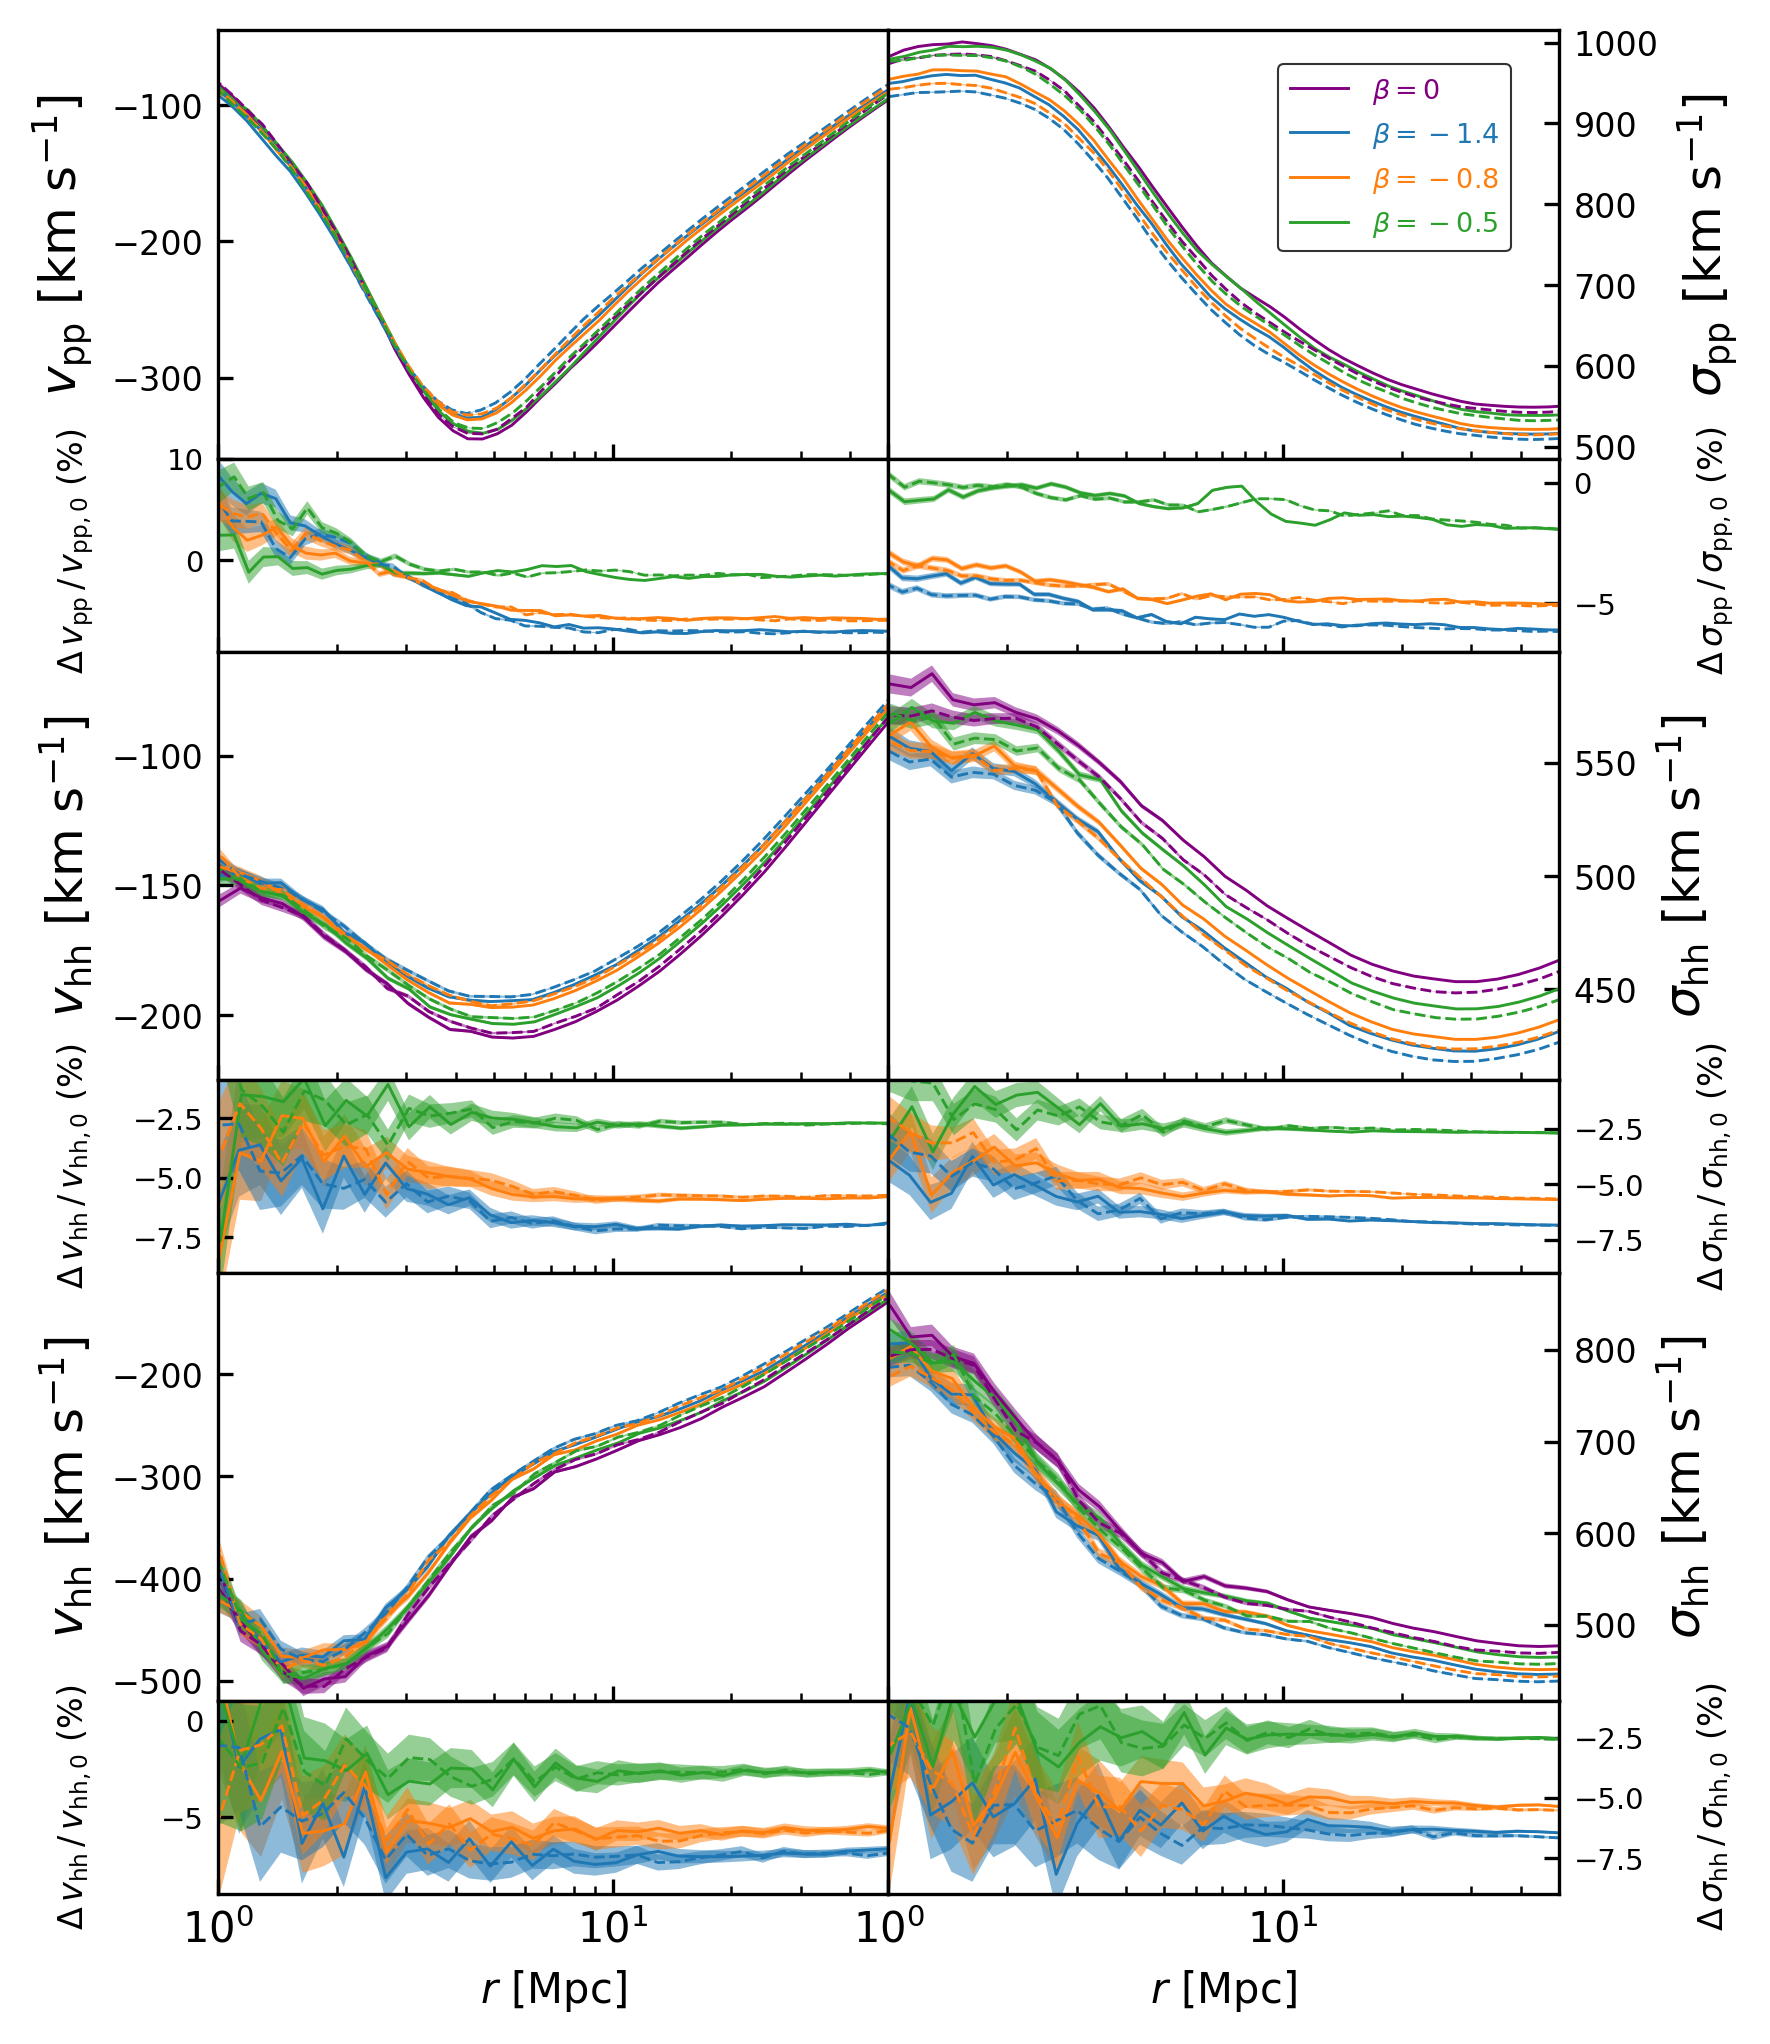

In [22]:
seed = [1, 16180]
case = ["0e+0_A0", "-1.4e+0_A1", "-8e-1_A4", "-5e-1_A7"]
index = [1, 4, 7]
texts = ["$\\beta = 0$", "$\\beta = -1.4$", "$\\beta = -0.8$", "$\\beta = -0.5$"]
file_names_1_pp = ['/Users/kinho123/Downloads/mphil_project/pwv/vpp_1024_DESI/seed_1_vpp_2018/type3_mom_{}_fpart_0.01_r_0.50_36.00.txt'.format(i)  for i in case ]
file_names_16180_pp = ['/Users/kinho123/Downloads/mphil_project/pwv/vpp_1024_DESI/seed_16180_vpp_2018/type3_mom_{}_fpart_0.01_r_0.50_36.00.txt'.format(i)  for i in case ]
file_names_1_hh_light = ['/Users/kinho123/Downloads/mphil_project/pwv/vhh_1024/T3_DESI/seed_1/MOM_{}_m200_1.0e+11_1.0e+13.txt'.format(i[-2:])  for i in case ]
file_names_16180_hh_light = ['/Users/kinho123/Downloads/mphil_project/pwv/vhh_1024/T3_DESI/seed_16180/MOM_{}_m200_1.0e+11_1.0e+13.txt'.format(i[-2:])  for i  in case ]
file_names_1_hh_heavy = ['/Users/kinho123/Downloads/mphil_project/pwv/vhh_1024/T3_DESI/seed_1/MOM_{}_m200_1.0e+13_1.0e+15.txt'.format(i[-2:])  for i in case ]
file_names_16180_hh_heavy = ['/Users/kinho123/Downloads/mphil_project/pwv/vhh_1024/T3_DESI/seed_16180/MOM_{}_m200_1.0e+13_1.0e+15.txt'.format(i[-2:])  for i  in case ]

# Labels for each file
labels = [r'{}'.format(i) for i in case]

# Plot settings
font_size = 12
plot_xmin = 1
plot_xmax = 50

linewidth = 0.7
# Create a figure with gridspec
fig = plt.figure(figsize=(6, 7), dpi=300)
gs = fig.add_gridspec(6, 2, height_ratios=[2, 0.9, 2, 0.9, 2, 0.9])

# Create axes
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
ax3 = fig.add_subplot(gs[2, 0], sharex=ax1)
ax4 = fig.add_subplot(gs[3, 0], sharex=ax1)
ax5 = fig.add_subplot(gs[4, 0], sharex=ax1)
ax6 = fig.add_subplot(gs[5, 0], sharex=ax1)
ax7 = fig.add_subplot(gs[0, 1])
ax8 = fig.add_subplot(gs[1, 1], sharex=ax1)
ax9 = fig.add_subplot(gs[2, 1], sharex=ax1)
ax10 = fig.add_subplot(gs[3, 1], sharex=ax1)
ax11 = fig.add_subplot(gs[4, 1], sharex=ax1)
ax12 = fig.add_subplot(gs[5, 1], sharex=ax1)

# Function to process and plot data

def process_and_plot(file_names, seed_num, linestyle, ax_a, ax_b, ax_c, ax_d):
    vpp_ref, vpp_ref_error = None, None
    sigmapp_ref, sigmapp_ref_error = None, None
    for i, file_name in enumerate(file_names):
        radius, pair_number, v12_tot, v12_tot_error, v12_los, v12_los_error, v12_per, v12_per_error, d12_tot, d12_tot_error, d12_los, d12_los_error, d12_per, d12_per_error = np.loadtxt(file_name, skiprows=1, unpack=True)
        rad_mpc = radius / h_0_case[i]
        
        if i == 0:
            vpp_ref, vpp_ref_error = v12_los, v12_los_error
            sigmapp_ref, sigmapp_ref_error = d12_los, d12_los_error
        
        v_ratio = v12_los / vpp_ref
        sigma_ratio = d12_los / sigmapp_ref
        v_deviation = (v_ratio - 1) * 1e2
        sigma_deviation = (sigma_ratio - 1) * 1e2
        v_error_ratio = v_ratio * np.sqrt((v12_los_error/v12_los)**2 + (vpp_ref_error/vpp_ref)**2) * 1e2
        sigma_error_ratio = sigma_ratio * np.sqrt((d12_los_error/d12_los)**2 + (sigmapp_ref_error/sigmapp_ref)**2) * 1e2
        
        color = TABLEAU_COLORS[i]
        label = f"{labels[i]} (seed {seed_num})" if seed_num == 1 else None
        
        # Plot v12_los and d12_los with labels
        ax_a.plot(rad_mpc, v12_los, color=color, linestyle=linestyle, label=label, linewidth=linewidth) 
        ax_a.fill_between(rad_mpc, v12_los + v12_los_error, v12_los - v12_los_error, facecolor=color, alpha=0.5)
        ax_c.plot(rad_mpc, d12_los, color=color, linestyle=linestyle, label=label, linewidth=linewidth)  # Add label here
        ax_c.fill_between(rad_mpc, d12_los + d12_los_error, d12_los - d12_los_error, facecolor=color, alpha=0.5)

        if i != 0:
            ax_b.plot(rad_mpc, v_deviation, color=color, linestyle=linestyle, linewidth=linewidth)
            ax_b.fill_between(rad_mpc, v_deviation + v_error_ratio, v_deviation - v_error_ratio, facecolor=color, alpha=0.5)
            ax_d.plot(rad_mpc, sigma_deviation, color=color, linestyle=linestyle, linewidth=linewidth)
            ax_d.fill_between(rad_mpc, sigma_deviation + sigma_error_ratio, sigma_deviation - sigma_error_ratio, facecolor=color, alpha=0.5)

# Process and plot both seeds
process_and_plot(file_names_1_pp, 1, '-', ax1, ax2, ax7, ax8)
process_and_plot(file_names_16180_pp, 16180, '--',  ax1, ax2, ax7, ax8)
process_and_plot(file_names_1_hh_light, 1, '-', ax3, ax4, ax9, ax10)
process_and_plot(file_names_16180_hh_light, 16180, '--', ax3, ax4, ax9, ax10)
process_and_plot(file_names_1_hh_heavy, 1, '-', ax5, ax6, ax11, ax12)
process_and_plot(file_names_16180_hh_heavy, 16180, '--', ax5, ax6, ax11, ax12)


# Create legends
legend = ax7.legend(fontsize=7, loc='lower right',bbox_to_anchor=(0.95, 0.45), edgecolor='black')
legend.get_frame().set_linewidth(0.5)
for i, text in enumerate(legend.get_texts()):
    text.set_text(texts[i])
    text.set_color(TABLEAU_COLORS[i])
    text.set_fontsize(6.5)

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='k', linestyle='-', label='Seed 1'),
                   Line2D([0], [0], color='k', linestyle='--', label='Seed 16180')]
#legend2 = ax1.legend(handles=legend_elements, loc='upper right', fontsize=12, edgecolor='black')
#legend2.get_frame().set_linewidth(0.5)

# Axis labels and settings


# Add common y-label
pos_ax2 = ax1.get_position()
pos_ax4 = ax3.get_position()
pos_ax6 = ax5.get_position()

pos_ax8 = ax7.get_position()
pos_ax10 = ax9.get_position()
pos_ax12 = ax11.get_position()

fig.text(0.039, (pos_ax2.y0) - 0.01, '$\Delta  \, v_{\mathrm{pp}} \, /\,v_{\mathrm{pp,0}}  \,\, (\%) $'  # Example label
         ,va='center', rotation='vertical', fontsize=8)
fig.text(0.039, (pos_ax4.y0) -0.039, '$\Delta  \, v_{\mathrm{hh}} \, /\,v_{\mathrm{hh,0}}  \,\, (\%) $'  # Example label
         ,va='center', rotation='vertical', fontsize=8)
fig.text(0.039, (pos_ax6.y0) -0.08, '$\Delta  \, v_{\mathrm{hh}} \, /\,v_{\mathrm{hh,0}}  \,\, (\%) $'  # Example label
         ,va='center', rotation='vertical', fontsize=8)
fig.text(0.95, (pos_ax8.y0) - 0.01, '$\Delta  \, \sigma_{\mathrm{pp}} \, /\,\sigma_{\mathrm{pp,0}}  \,\, (\%) $'  # Example label
         ,va='center', rotation='vertical', fontsize=8)
fig.text(0.95, (pos_ax10.y0) -0.039, '$\Delta  \, \sigma_{\mathrm{hh}} \, /\,\sigma_{\mathrm{hh,0}}  \,\, (\%) $'  # Example label
         ,va='center', rotation='vertical', fontsize=8)
fig.text(0.95, (pos_ax12.y0) -0.08, '$\Delta  \, \sigma_{\mathrm{hh}} \, /\,\sigma_{\mathrm{hh,0}}  \,\, (\%) $'  # Example label
         ,va='center', rotation='vertical', fontsize=8)

ax1.set_ylabel('$v_{\mathrm{pp}} \,\, [\\mathrm{km}$ $\\mathrm{s}^{-1}]$', fontsize=font_size)
ax3.set_ylabel('$v_{\mathrm{hh}} \,\, [\\mathrm{km}$ $\\mathrm{s}^{-1}]$', fontsize=font_size)
ax5.set_ylabel('$v_{\mathrm{hh}} \,\, [\\mathrm{km}$ $\\mathrm{s}^{-1}]$', fontsize=font_size)

ax7.set_ylabel('$\\sigma_{\mathrm{pp}} \,\, [\\mathrm{km}$ $\\mathrm{s}^{-1}]$', fontsize=font_size)
#ax8.set_ylabel('$\Delta  \, \\sigma \, /\, \\sigma  \,\, (\%) $', fontsize=8)
ax9.set_ylabel('$\\sigma_{\mathrm{hh}} \,\, [\\mathrm{km}$ $\\mathrm{s}^{-1}]$', fontsize=font_size)
#ax10.set_ylabel('$\Delta  \, \\sigma \, /\, \\sigma  \,\, (\%) $', fontsize=8)
ax11.set_ylabel('$\\sigma_{\mathrm{hh}} \,\, [\\mathrm{km}$ $\\mathrm{s}^{-1}]$', fontsize=font_size)
#ax12.set_ylabel('$\Delta  \, \\sigma \, /\, \\sigma  \,\, (\%) $', fontsize=8)

ax2.set_ylim(-9, 10)
ax3.set_ylim(-225, -60)
ax4.set_ylim(-9, -0.9)
ax5.set_ylim(-520, -101)
ax6.set_ylim(-9, 1)
ax7.set_ylim(485, 1015)
ax8.set_ylim(-7, 1)
ax9.set_ylim(410, 599)
ax10.set_ylim(-9, -0.3)
ax12.set_ylim(-9, -1)

for ax in [ax7, ax8, ax9, ax10, ax11, ax12]:
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position('right')

axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12]
for ax in axes:
    for major in axes[0::2]:
        
        major.tick_params(axis='y', which='both', direction='in', labelsize=8)
    else:
        ax.tick_params(axis='y', which='both', direction='in', labelsize=7)
    if ax != ax6 and ax != ax12 :
        ax.tick_params(axis='x', which='both', direction='in', labelbottom=False)
    else:
        ax.tick_params(axis='x', which='both', direction='in')
        ax.set_xlabel('$r \,\, [\\mathrm{Mpc}]$', fontsize=10)
    ax.set_xlim(plot_xmin, plot_xmax)
    ax.set_xscale('log')
plt.tight_layout()
plt.subplots_adjust(hspace=0, wspace=0)

plt.savefig(r'/Users/kinho123/Downloads/mphil_project/pwv/Cosmic_variance_DESI.pdf', bbox_inches='tight')
plt.show()